In [1]:
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, broom, zoo, hrbrthemes)
theme_set(lal_plot_theme_d())

options(repr.plot.width = 15, repr.plot.height = 12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "broom"      TRUE  
[7,] "zoo"        TRUE  
[8,] "hrbrthemes" TRUE  


# Covidtracking Project data viz
https://covidtracking.com/api

In [2]:
system("rm -f data/daily.csv")
system("curl https://covidtracking.com/api/v1/states/daily.csv > data/daily.csv")

In [3]:
state_tests = fread('data/daily.csv')
state_tests[, d := anydate(date)]
state_tests[, day := weekdays(d)]
dropcols = c('hash', 'dateChecked')
state_tests[, (dropcols) := NULL]
state_tests %>% glimpse()

Rows: 6,121
Columns: 39
$ date                     <int> 20200622, 20200622, 20200622, 20200622, 2020…
$ state                    <chr> "AK", "AL", "AR", "AS", "AZ", "CA", "CO", "C…
$ positive                 <int> 761, 30454, 16083, 0, 54586, 178054, 30539, …
$ negative                 <int> 90063, 318656, 240256, 174, 375204, 3233632,…
$ pending                  <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, 1546…
$ hospitalizedCurrently    <int> 13, 658, 237, NA, 1992, 4804, 256, 140, 155,…
$ hospitalizedCumulative   <int> NA, 2471, 1164, NA, 4185, NA, 5327, 10099, N…
$ inIcuCurrently           <int> NA, NA, NA, NA, 583, 1412, NA, NA, 50, NA, N…
$ inIcuCumulative          <int> NA, 725, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ onVentilatorCurrently    <int> 1, NA, 61, NA, 379, NA, NA, NA, 34, NA, NA, …
$ onVentilatorCumulative   <int> NA, 424, 186, NA, NA, NA, NA, NA, NA, NA, NA…
$ recovered                <int> 491, 15974, 10793, NA, 7581, NA, 4328, 7842,…
$ dataQualityGrade         <

In [4]:
state_tests[, tpr := positive / totalTestResults]
state_tests[, cfr := death / positive ]
state_tests[, tpr_new := positiveIncrease / totalTestResultsIncrease]
(most_affected = 
     state_tests[d == max(state_tests$d)][
    order(-positive)][
    1:10, 
    c("state", "d", "positive", "death", "positiveIncrease", "deathIncrease", 
      'totalTestResults', 'totalTestResultsIncrease', 'cfr',  'tpr', 'tpr_new')]
 )

state,d,positive,death,positiveIncrease,deathIncrease,totalTestResults,totalTestResultsIncrease,cfr,tpr,tpr_new
<chr>,<date>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
NY,2020-06-22,388488,24739,552,14,3452099,56780,0.06368,0.11254,0.009722
CA,2020-06-22,178054,5515,4230,20,3411686,92430,0.03097,0.05219,0.045764
NJ,2020-06-22,169415,12895,273,25,1267399,22432,0.07611,0.13367,0.012170
IL,2020-06-22,138224,6875,462,24,1380003,18219,0.04974,0.10016,0.025358
TX,2020-06-22,114881,2192,3280,10,1549009,22829,0.01908,0.07416,0.143677
MA,2020-06-22,107210,7874,149,16,780063,6743,0.07344,0.13744,0.022097
FL,2020-06-22,100217,3266,2926,12,1617487,18191,0.03259,0.06196,0.160849
PA,2020-06-22,82186,6426,456,3,667848,10103,0.07819,0.12306,0.045135
MI,2020-06-22,67957,6097,246,7,918017,10591,0.08972,0.07403,0.023227


In [5]:
t10states = state_tests[positive >= 10 & state %in% most_affected$state]

In [6]:
setorder(t10states, state, date)

smoothvars = c("positive", "hospitalizedCurrently", "cfr", "death", "totalTestResults", 
              "positiveIncrease", "hospitalizedIncrease", "deathIncrease", "totalTestResultsIncrease",
              'tpr', 'tpr_new')

t10states[, paste0("rm3_", smoothvars) := lapply(.SD, rollmean, k = 3, fill = NA, na.pad = T), 
   by = .(state), .SDcols = smoothvars]

# t10states[, tpr_rm3 := rollmeanr(tpr, 3, fill = NA), by = .(state)]

# Plots 

## Natl Time Series

In [7]:
nat_ts = state_tests[, lapply(.SD, sum, na.rm = T), by = d, 
                     .SDcols = c("positive", "positiveIncrease", "totalTestResults", "totalTestResultsIncrease", "death", "deathIncrease")][, 
    `:=`(cfr = death/positive,
         tpr = positive/totalTestResults,
         tpr_n = positiveIncrease/totalTestResultsIncrease
         )]

smoothvars = c("positive", "positiveIncrease", "death", "deathIncrease", "tpr_n", "cfr", "tpr", "totalTestResultsIncrease")

nat_ts[, paste0("rm3_", smoothvars) := lapply(.SD, rollmean, k = 3, fill = NA, na.pad = T), .SDcols = smoothvars]
nat_ts[, .(d, positive, positiveIncrease, death, deathIncrease, totalTestResults, totalTestResultsIncrease)] %>% head

d,positive,positiveIncrease,death,deathIncrease,totalTestResults,totalTestResultsIncrease
<date>,<int>,<int>,<int>,<int>,<int>,<int>
2020-06-22,2297383,27036,114034,284,27553581,464758
2020-06-21,2270347,27278,113750,298,27088823,512199
2020-06-20,2243069,31930,113452,630,26576624,566448
2020-06-19,2211139,31010,112822,648,26010176,571201
2020-06-18,2180129,27473,112174,697,25438975,517700
2020-06-17,2152656,23842,111477,782,24921275,488722


Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'



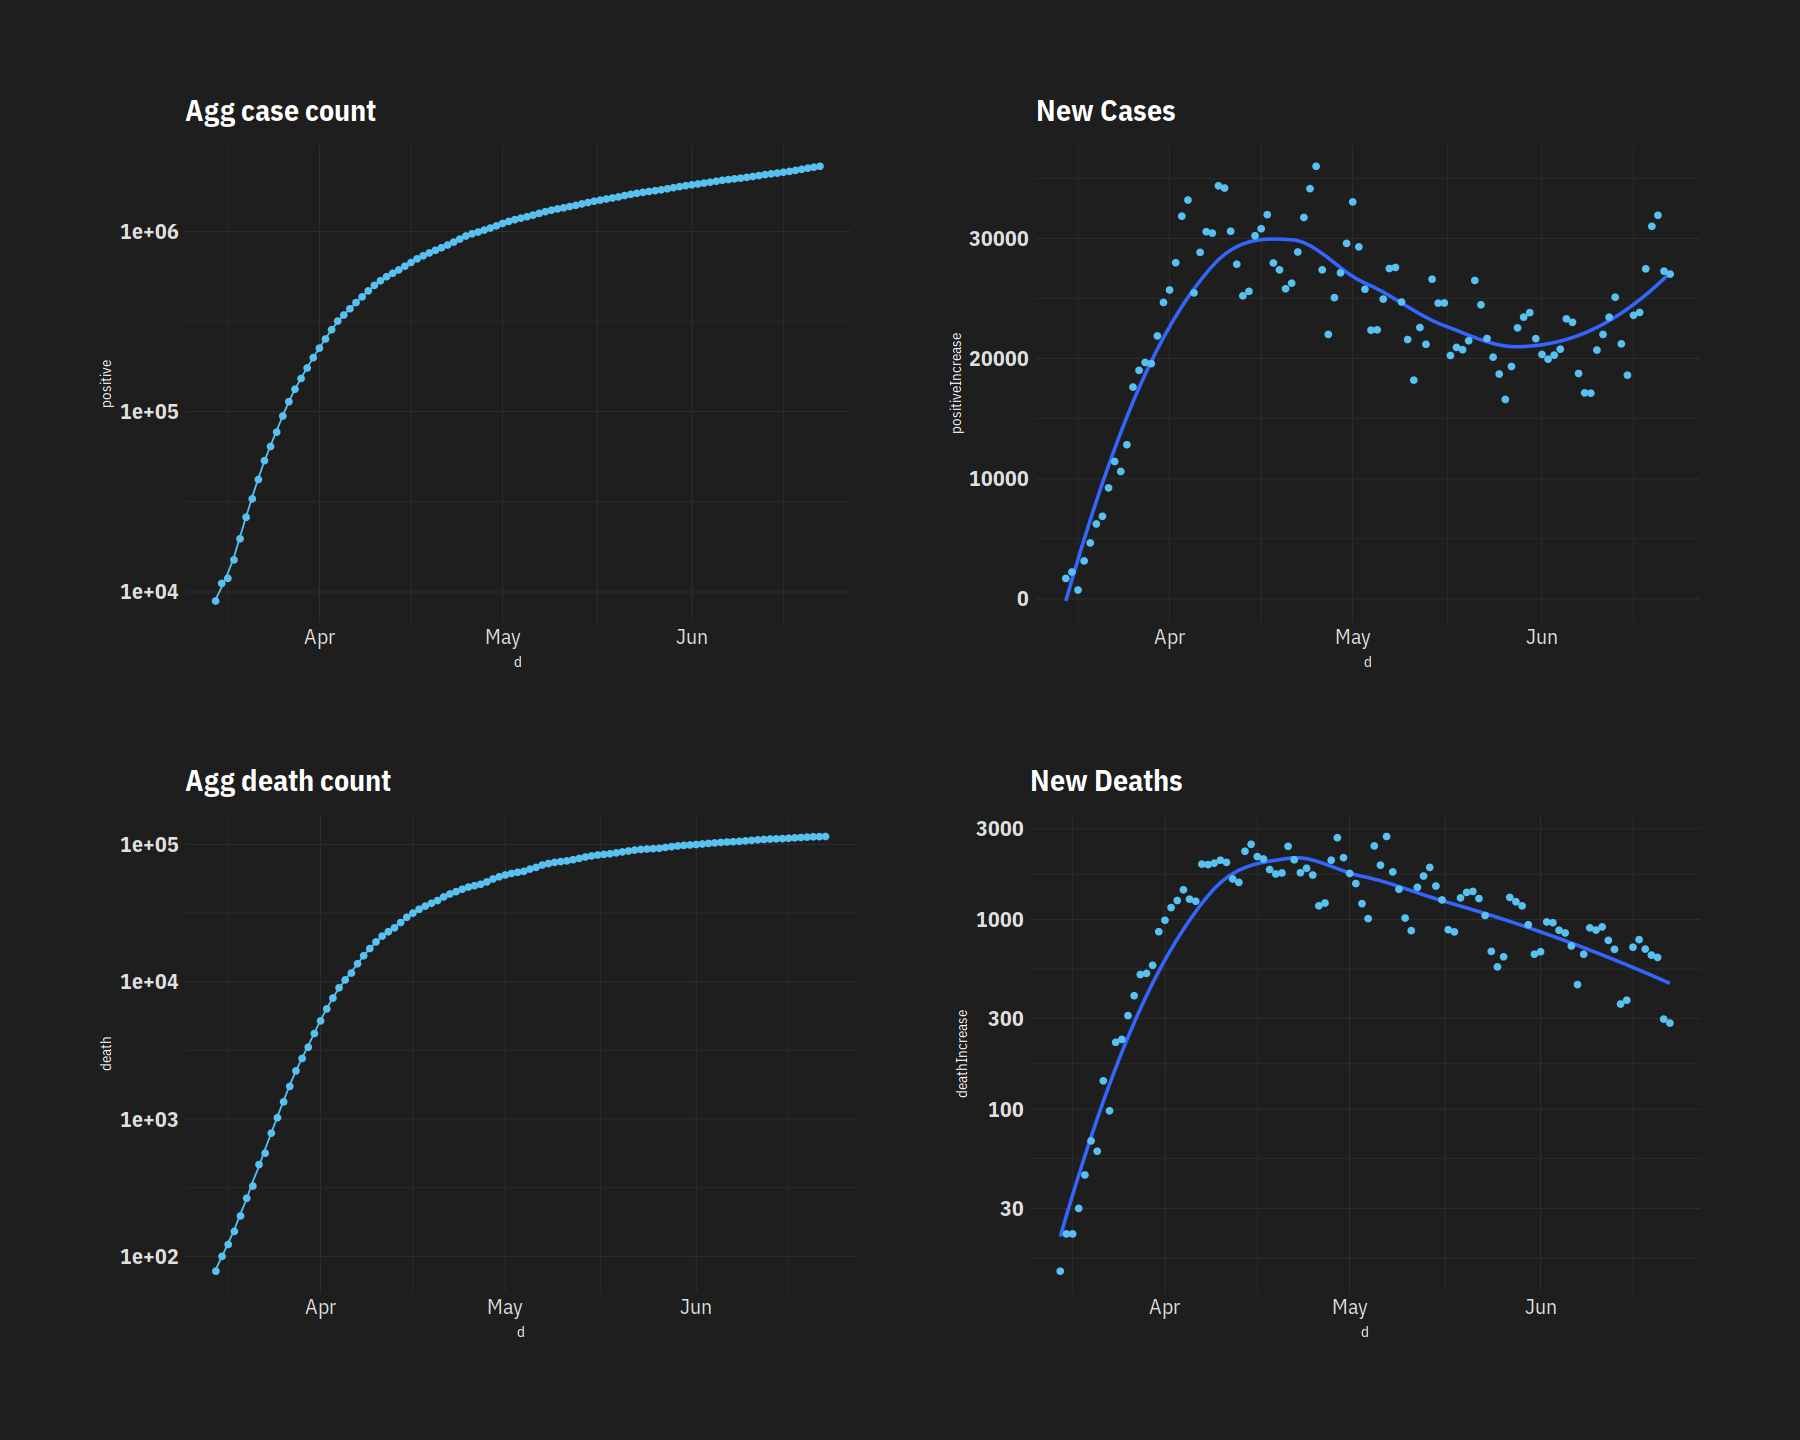

In [8]:
p1 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = positive)) + scale_y_log10() +
    geom_point() + geom_line(aes(y = rm3_positive)) + ggtitle("Agg case count")

p2 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = positiveIncrease)) + geom_smooth(se = F) + 
    geom_point() + ggtitle("New Cases")

p3 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = death)) + scale_y_log10() + geom_line(aes(y = rm3_death)) +
    geom_point() + ggtitle("Agg death count")

p4 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = deathIncrease)) + scale_y_log10() + geom_smooth(se = F) +
    geom_point() + ggtitle("New Deaths")

(p1 | p2)/(p3 | p4)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



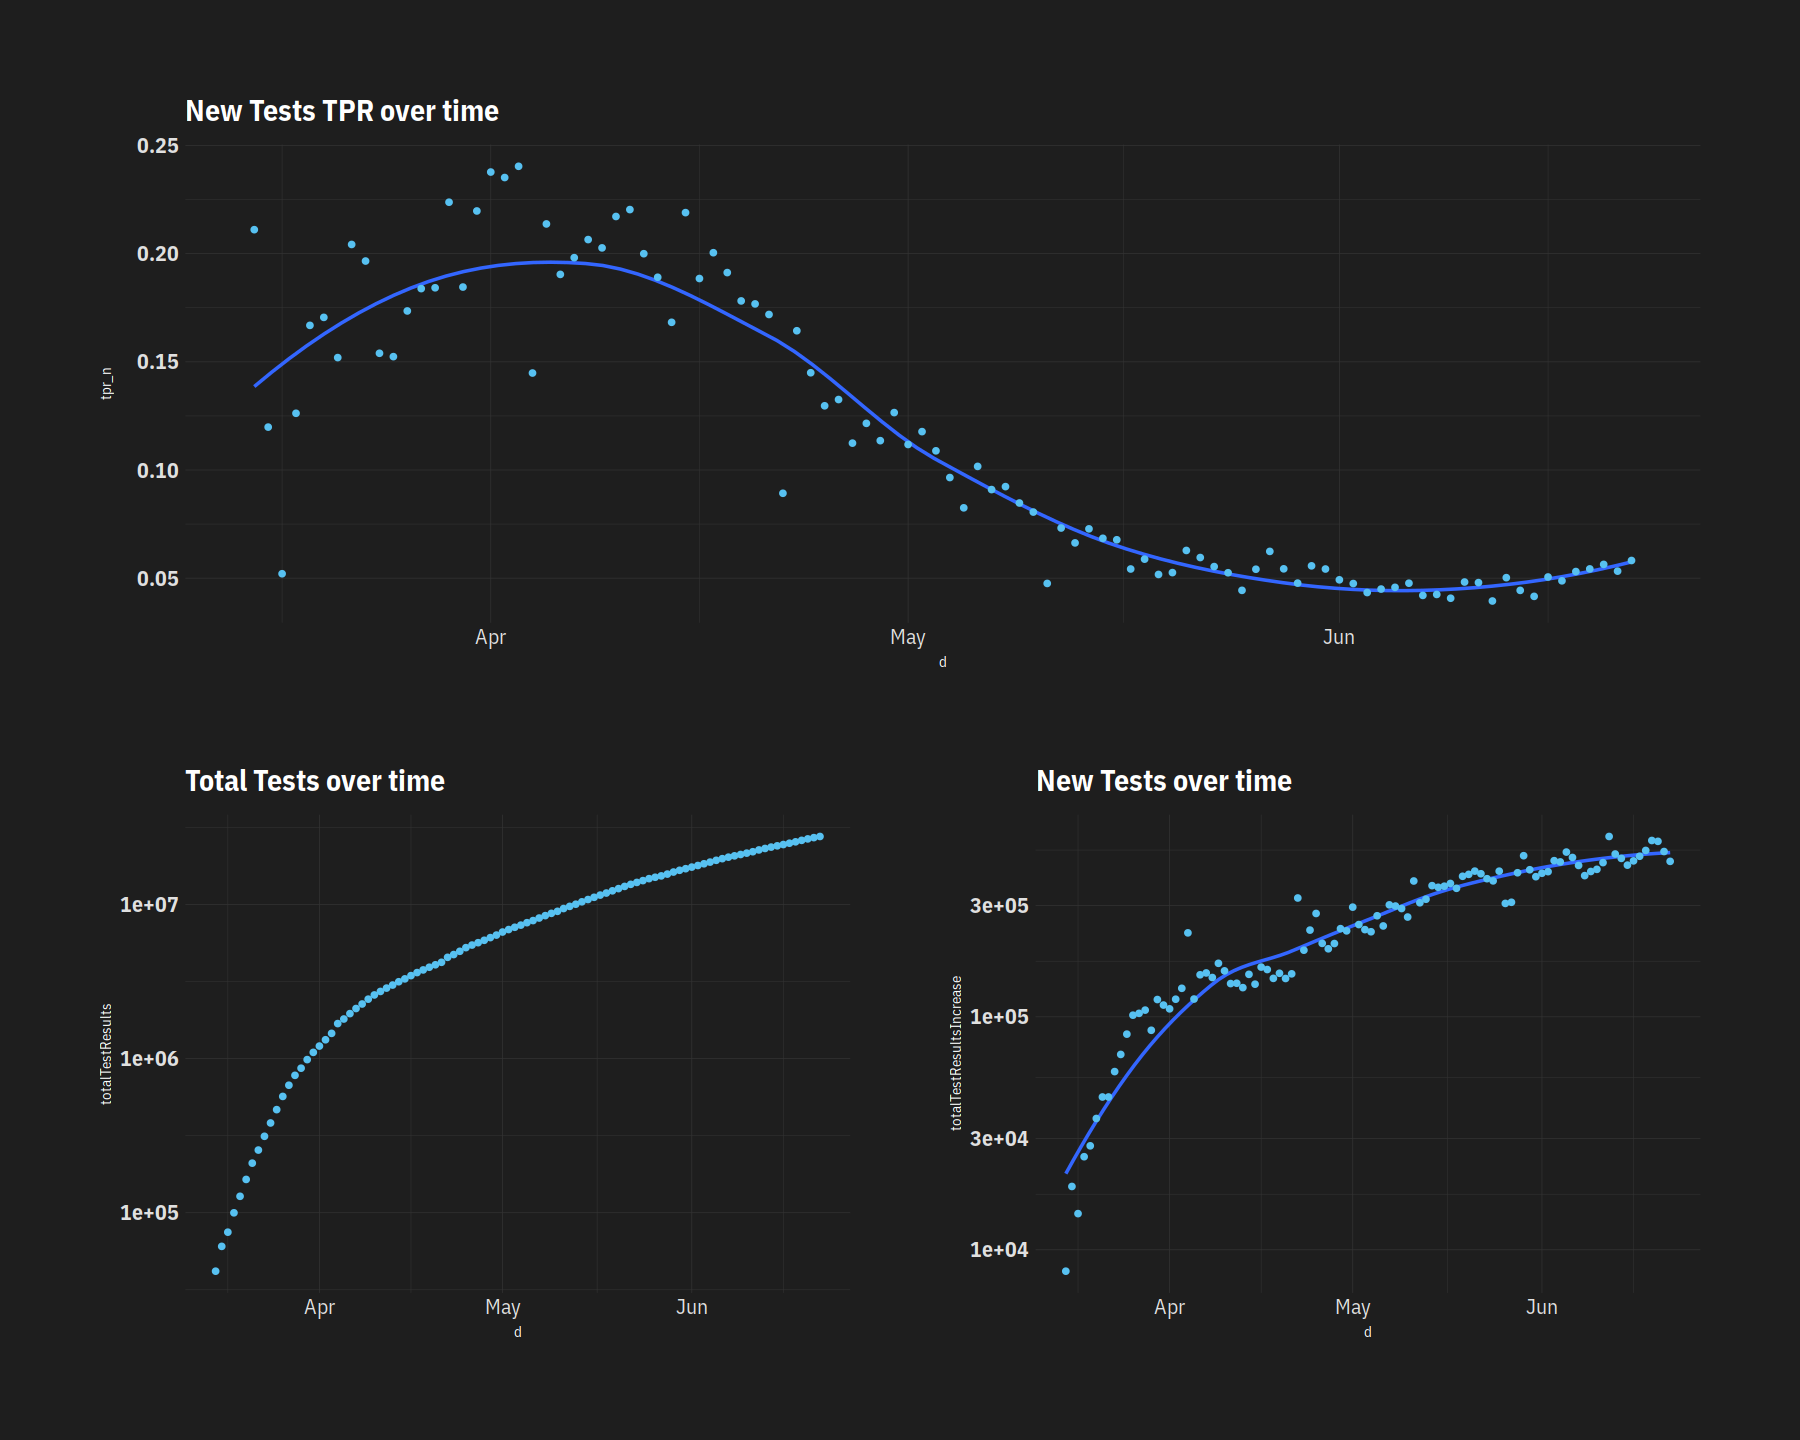

In [9]:
p1 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = tpr)) +
    geom_point() + geom_smooth(se = F) + ggtitle("TPR over time")

p2 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = tpr_n)) + geom_smooth(se = F) +
    geom_point() + ggtitle("New Tests TPR over time")
p3 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = totalTestResults)) + scale_y_log10() +
    geom_point() + ggtitle("Total Tests over time")

p4 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = totalTestResultsIncrease)) + 
    scale_y_log10() + geom_smooth(se = F) +
    geom_point() + ggtitle("New Tests over time")

p5 = nat_ts[d >= "2020-03-15"] %>% 
    ggplot(aes(x = d, y = cfr)) + geom_smooth(se = F) +
    geom_point() + ggtitle("CFR Estimate over time")
(p2)/(p3 | p4) # | p5

In [10]:
# generic function to plot time series
plot_ts = function(df, col, t = "Time Series of", logtransform = F, rm = T){
    p = ggplot(df, aes_string(x = 'd', y = col, colour = 'state', group = 'state')) +
        geom_point( size = 0.7) + 
        # plot rolling mean line
        scale_colour_brewer(palette = "Spectral") +
        labs(
            title = t,
            subtitle = paste(unique(df$state), collapse = ", ")
        )
    if (rm == T) {
        p = p + geom_line(aes_string(y = paste0("rm3_", col))) 
    } else{
        p = p + geom_smooth(se = F)
    }
    if (logtransform == T) p = p + scale_y_log10()
    return(p)
}

## Cases 

Warning message:
“Removed 20 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 9 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


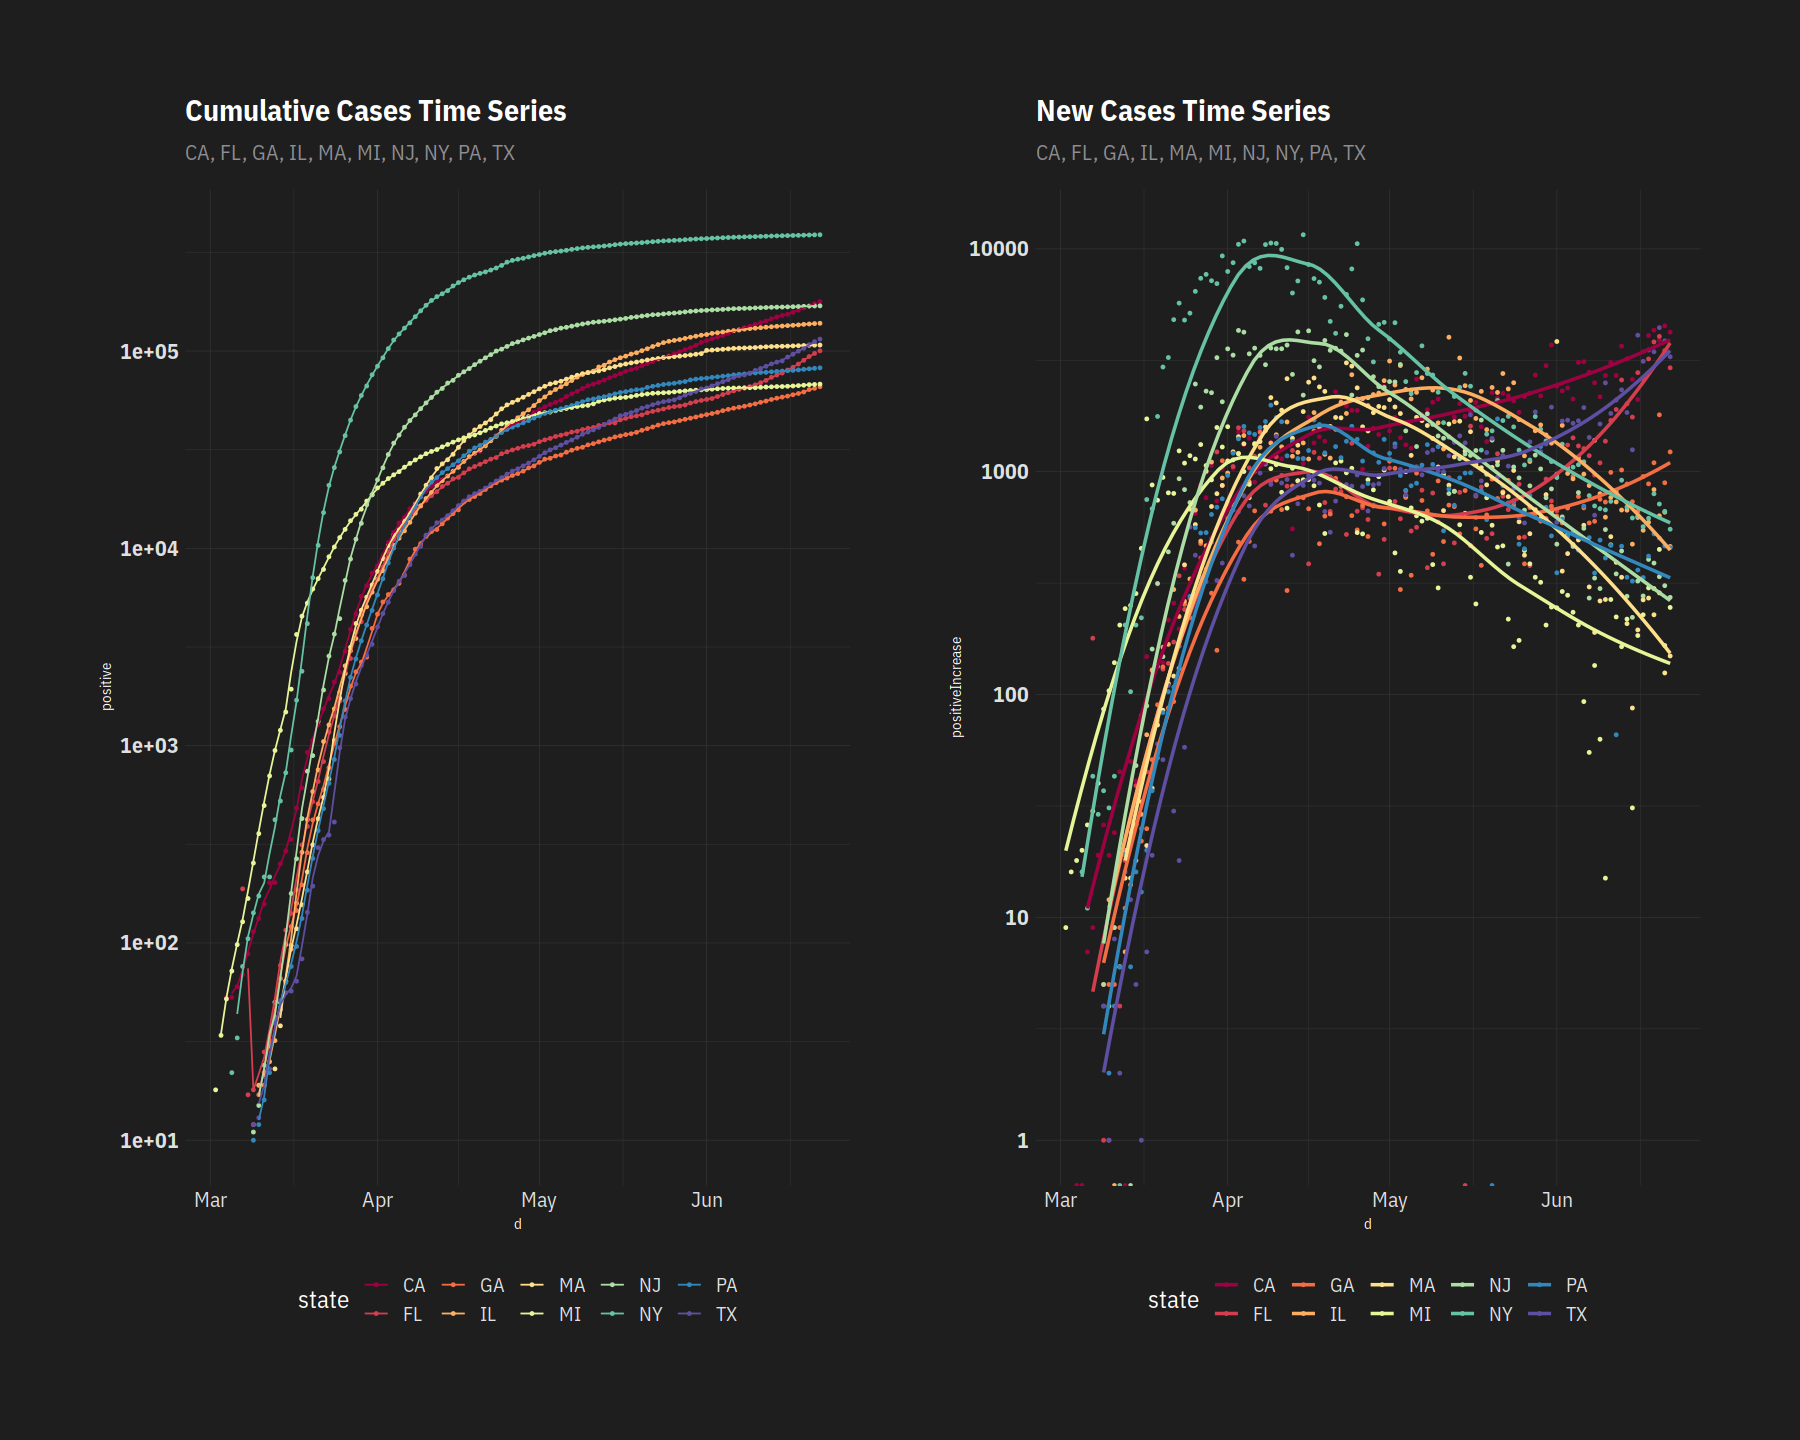

In [11]:
p1 = plot_ts(t10states, 'positive', "Cumulative Cases Time Series", T)
p2 = plot_ts(t10states, 'positiveIncrease', "New Cases Time Series", T, F)
(p1 | p2)

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 9 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


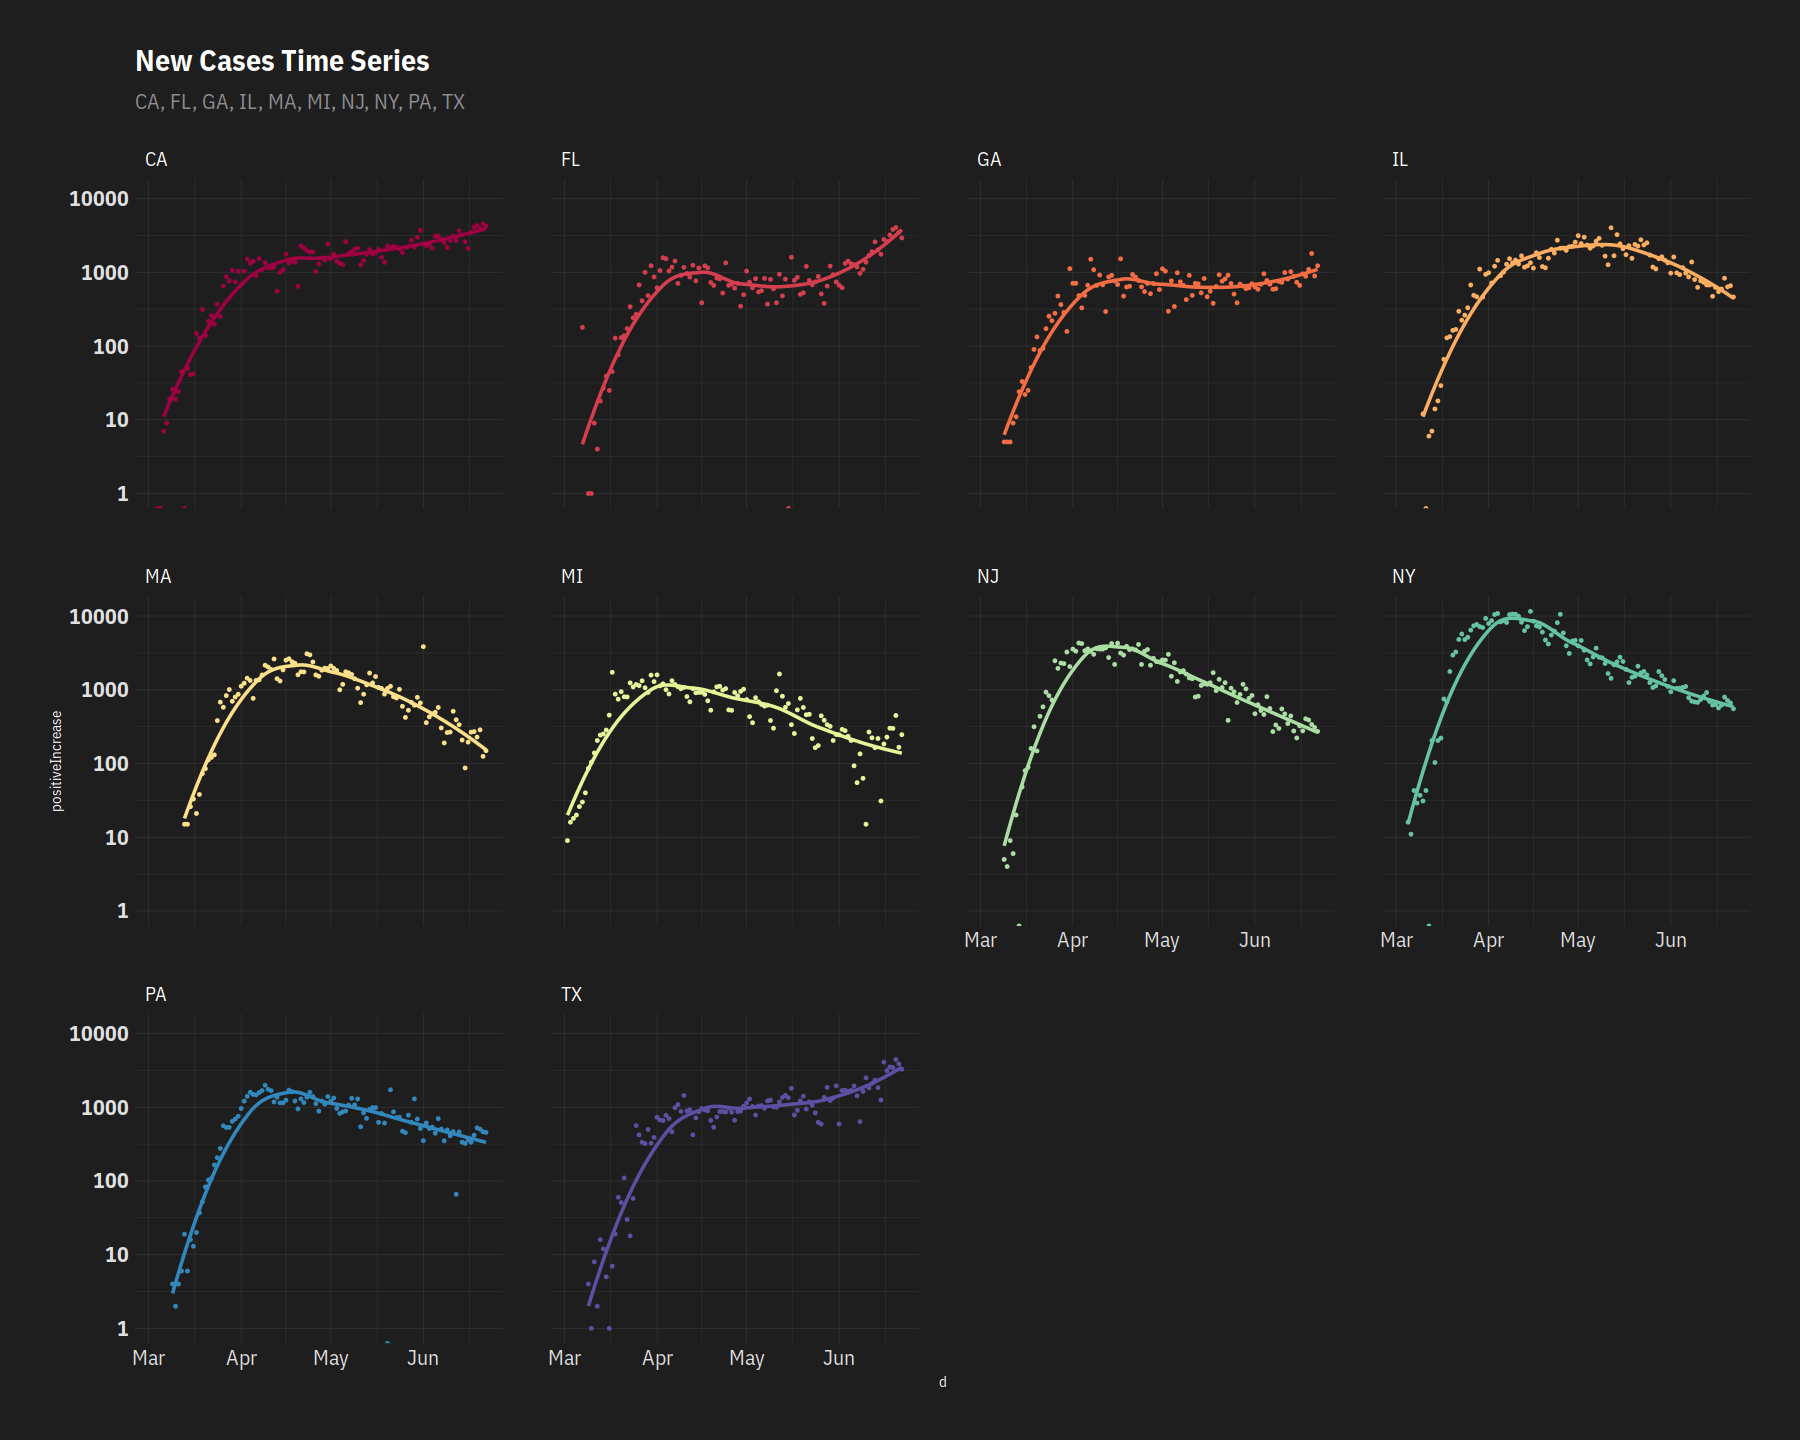

In [12]:
p2 + facet_wrap(~ state) + theme(legend.position = "None")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 72 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 72 rows containing missing values (geom_point).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 105 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


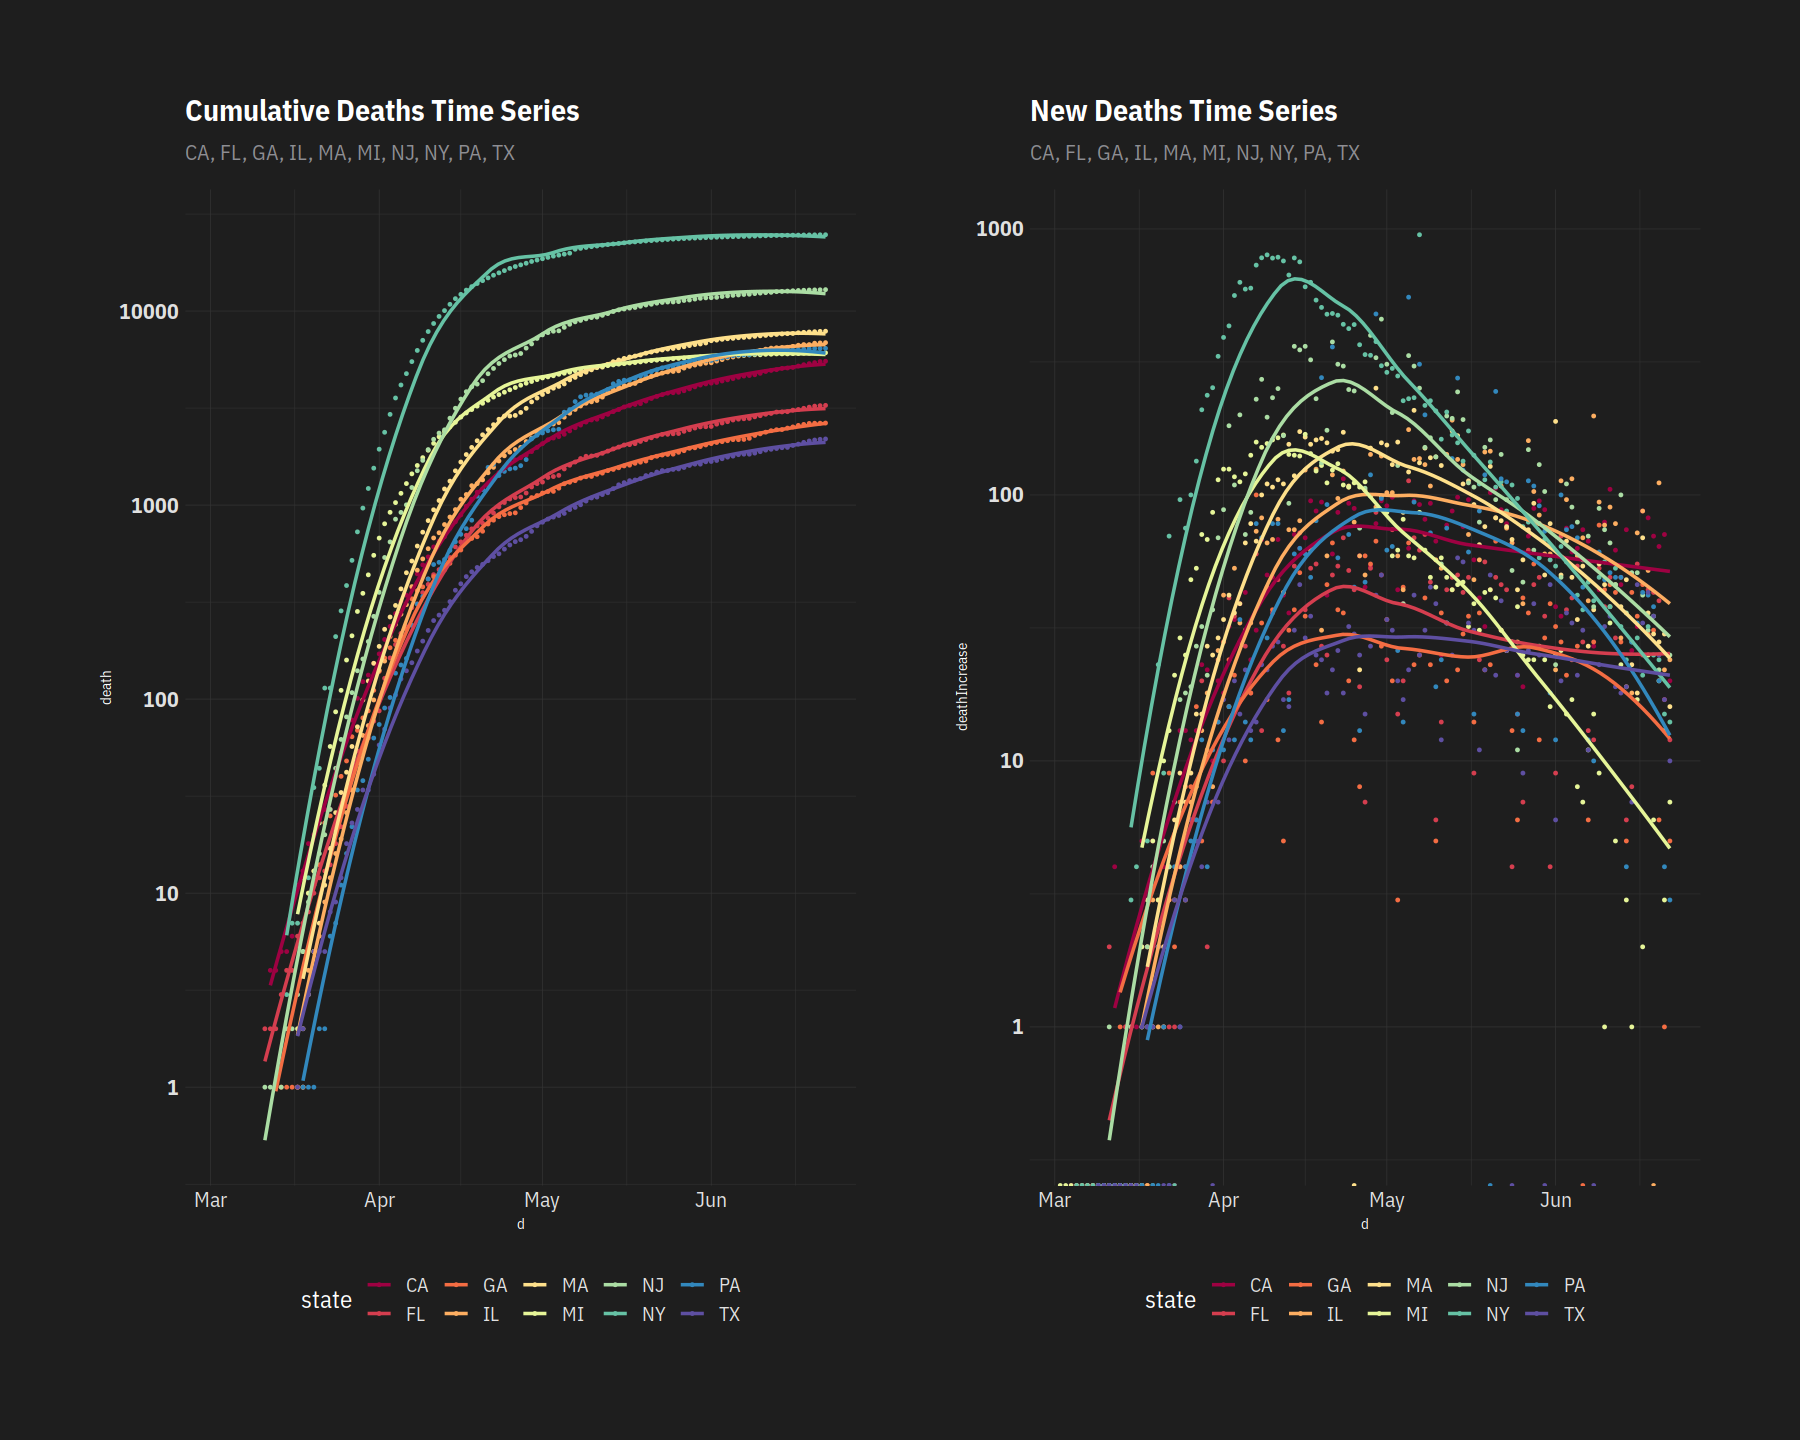

In [13]:
p1 = plot_ts(t10states, 'death', "Cumulative Deaths Time Series", T, F)
p2 = plot_ts(t10states, 'deathIncrease', "New Deaths Time Series", T, F)
(p1 | p2)

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 105 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


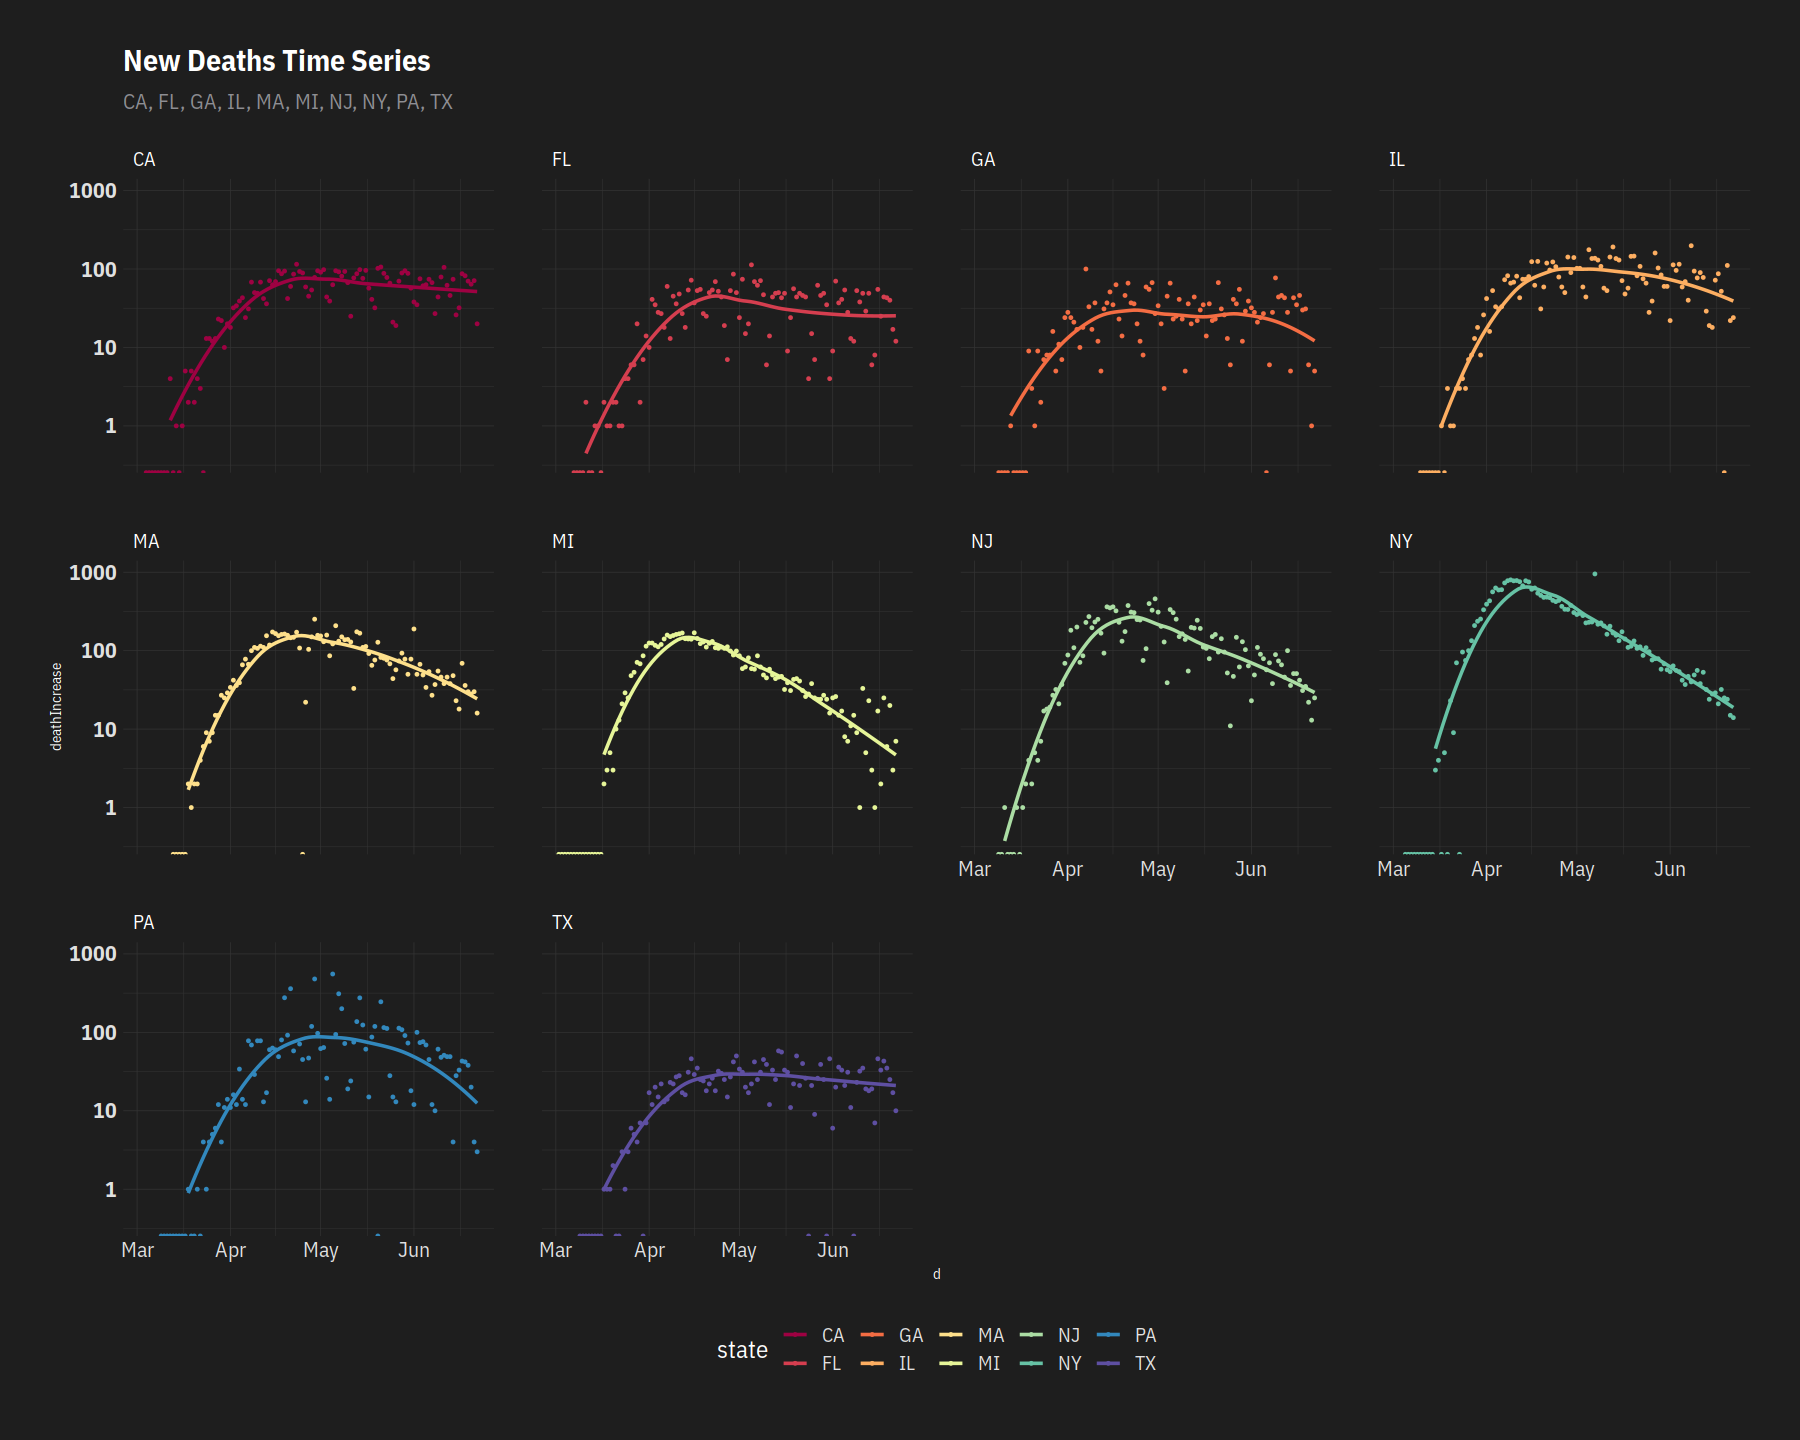

In [14]:
p2 + facet_wrap(~ state) 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 12 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_smooth).”


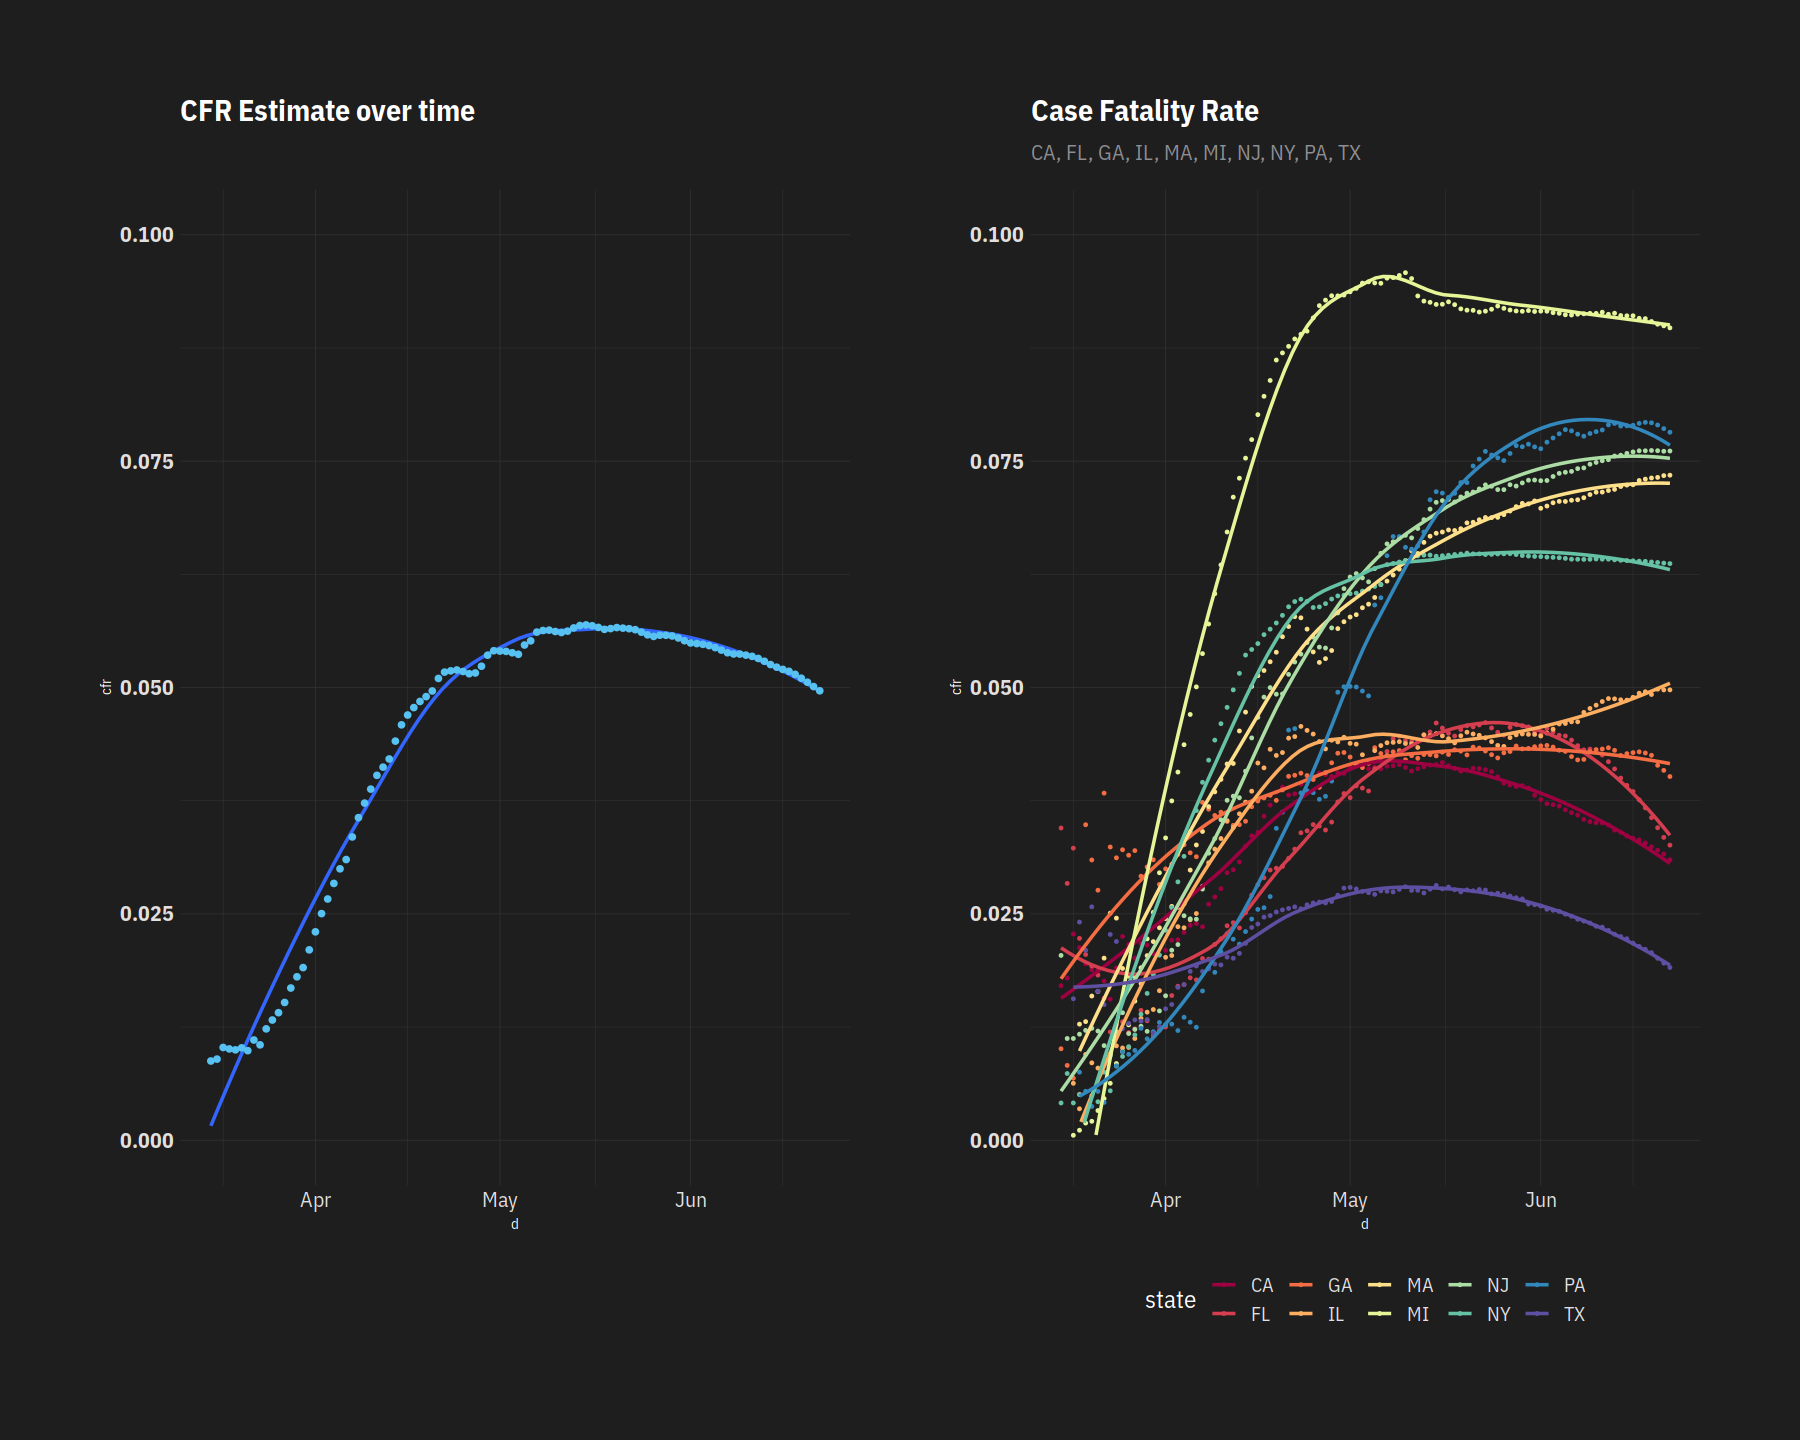

In [15]:
cfp = plot_ts(t10states[d >= "2020-03-15"], "cfr", "Case Fatality Rate", F, F)
p5 + ylim(c(0, 0.1)) | cfp+ ylim(c(0, 0.1)) 

## Tests 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


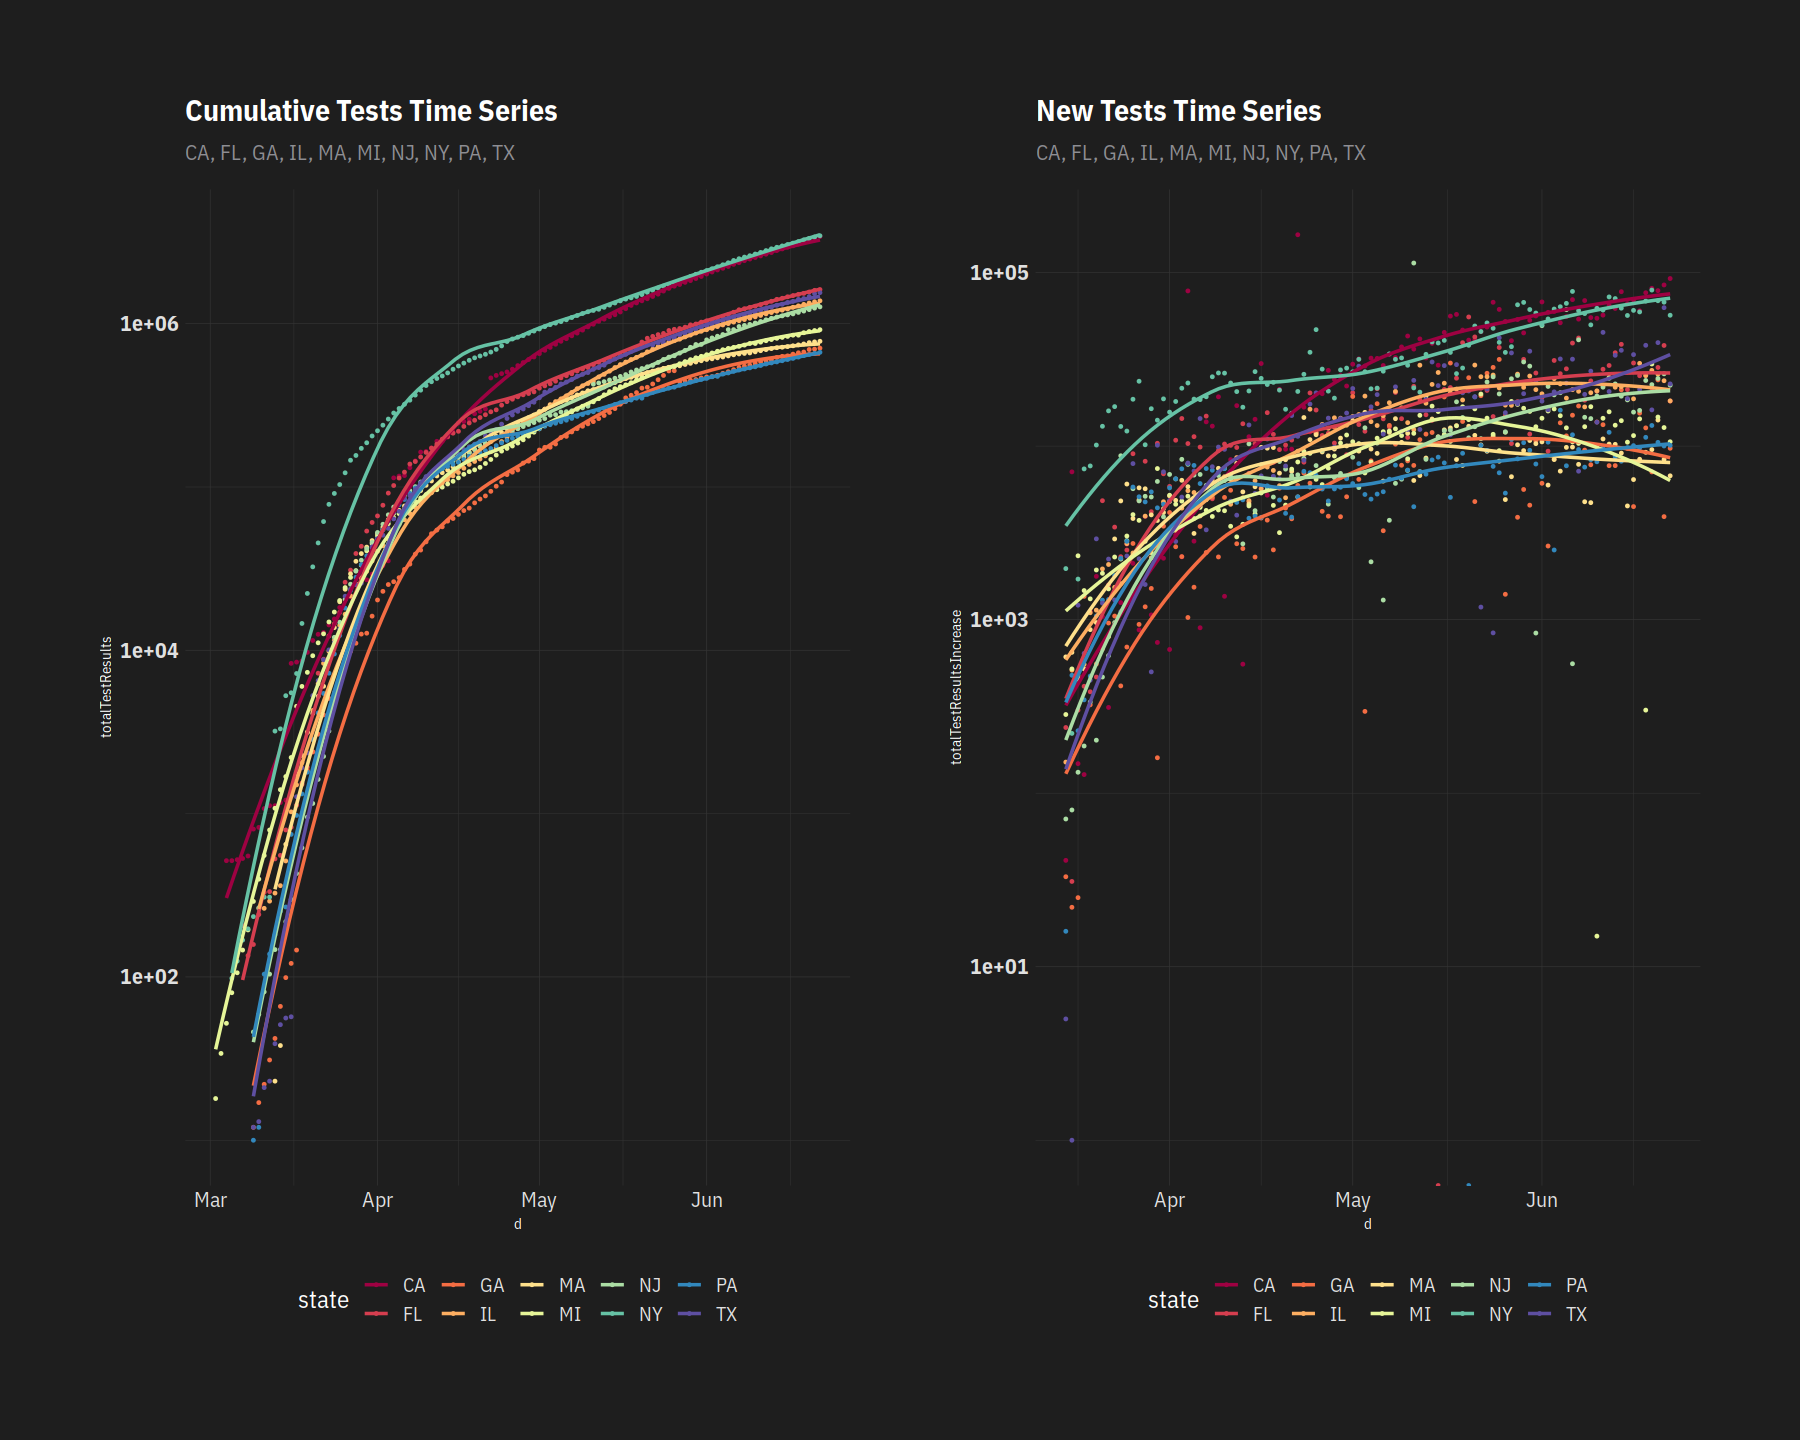

In [16]:
p = plot_ts(t10states, 'totalTestResults', "Cumulative Tests Time Series", T, F)
p2 = plot_ts(t10states[d >= '2020-03-15'], 'totalTestResultsIncrease', "New Tests Time Series", T, F)

(p | p2)

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


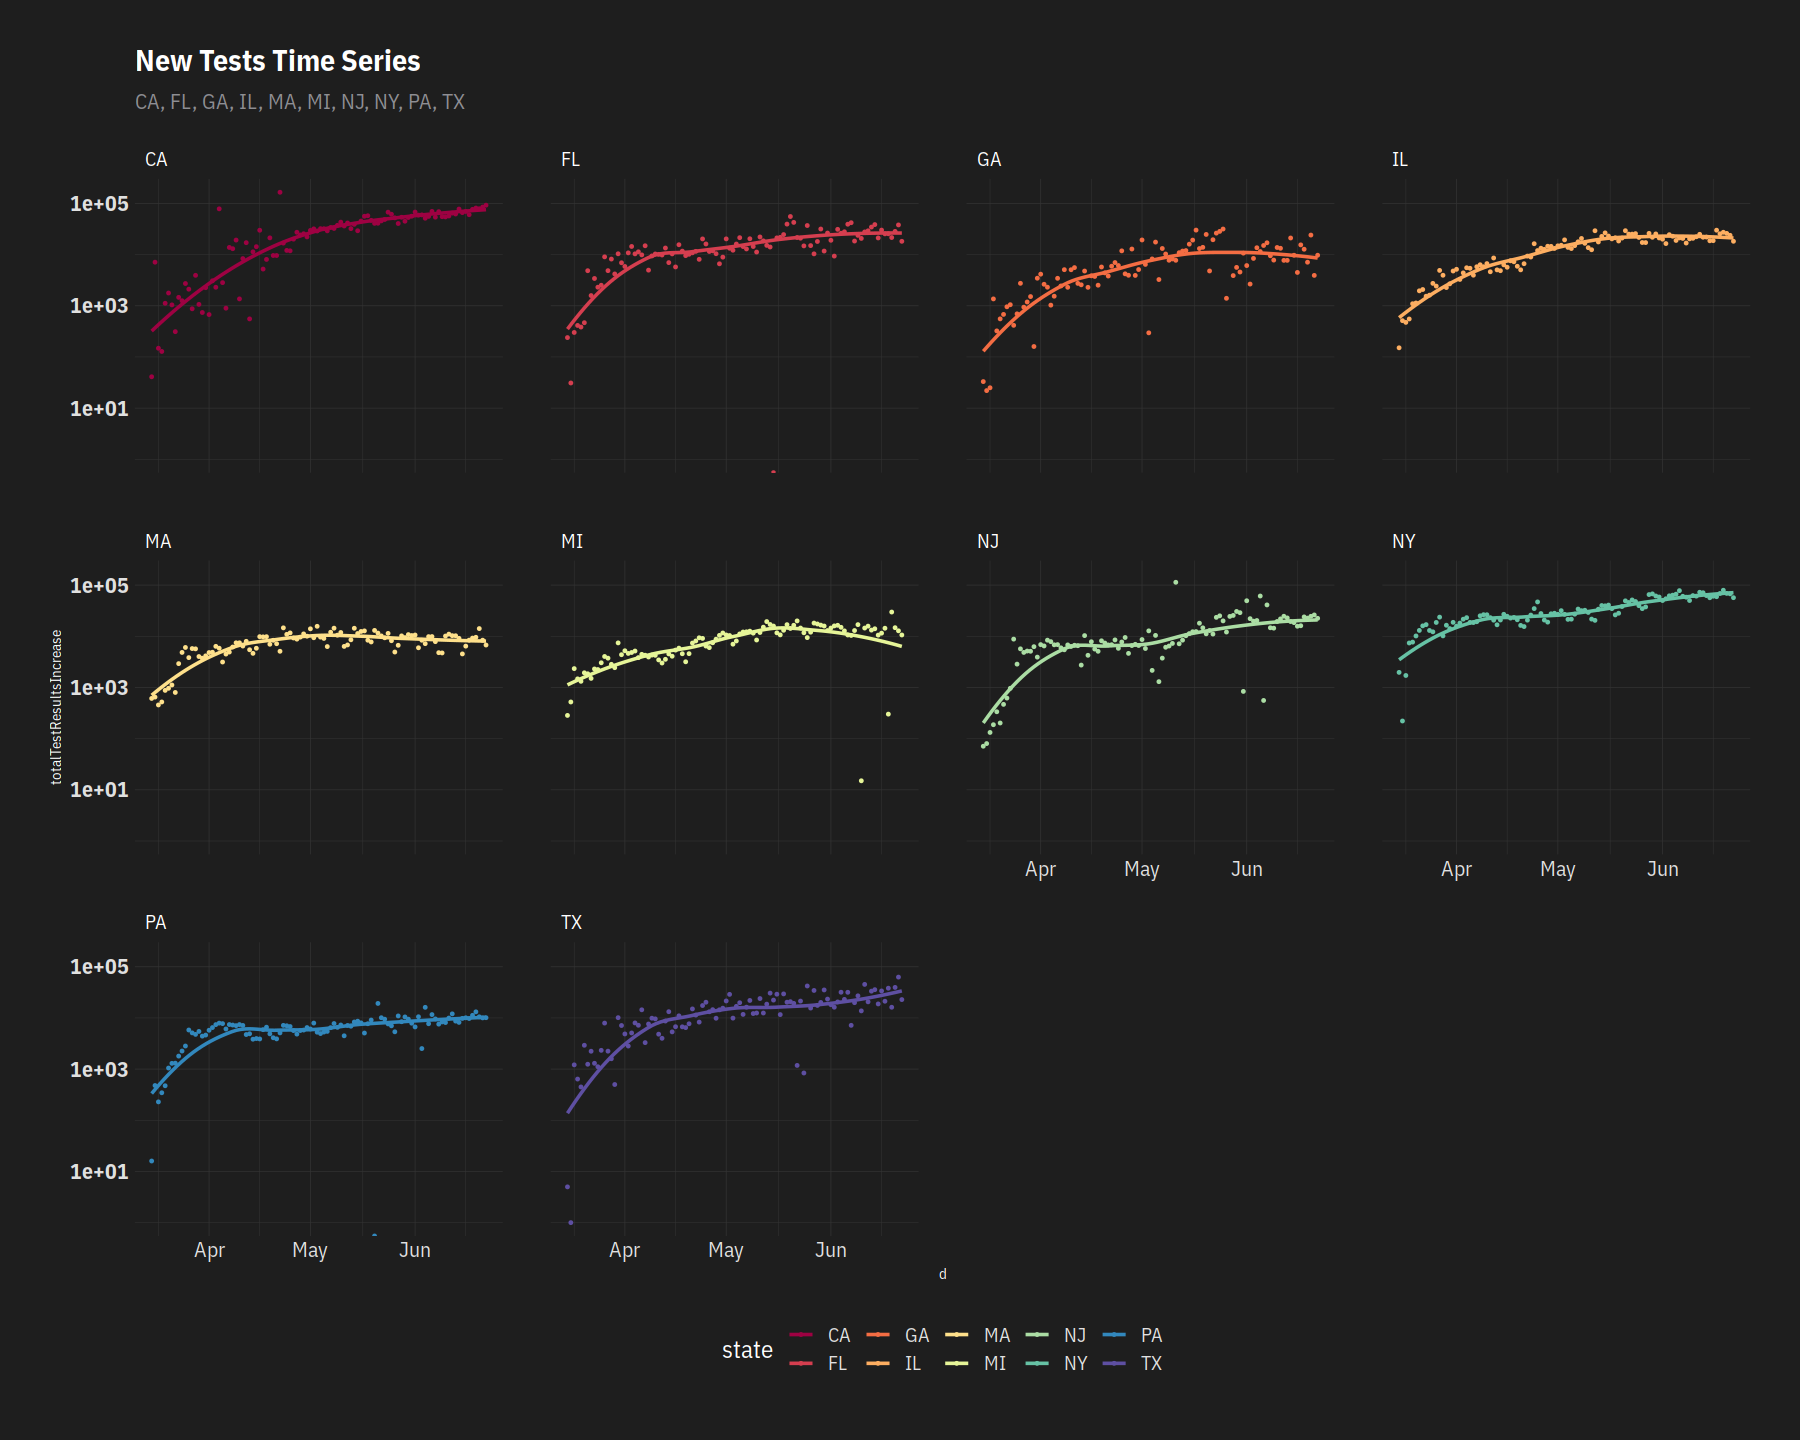

In [17]:
p2 + facet_wrap(~ state) 

# Shares over time  

In [18]:
t10states[rm3_deathIncrease < 0, rm3_deathIncrease := 0]
t10states[rm3_positiveIncrease< 0, rm3_positiveIncrease := 0]
t10states[rm3_totalTestResultsIncrease< 0, rm3_totalTestResultsIncrease := 0]

t10states[, denom_cases := sum(rm3_positiveIncrease), by = d][, 
            denom_deaths := sum(rm3_deathIncrease), by = d][,
            denom_tests  := sum(rm3_totalTestResultsIncrease), by = d]

t10states[, newcase_share := rm3_positiveIncrease / denom_cases][, 
            newdeath_share := rm3_deathIncrease/denom_deaths][,
            newtests_share := rm3_totalTestResultsIncrease / denom_tests]

In [19]:
t10states[, stgroup := case_when(
    state %in% c("NY", "NJ", "MA", "CT", "PA") ~ paste0("1_", state), # group northeast
    TRUE ~ paste0("2_", state)
)]

Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”


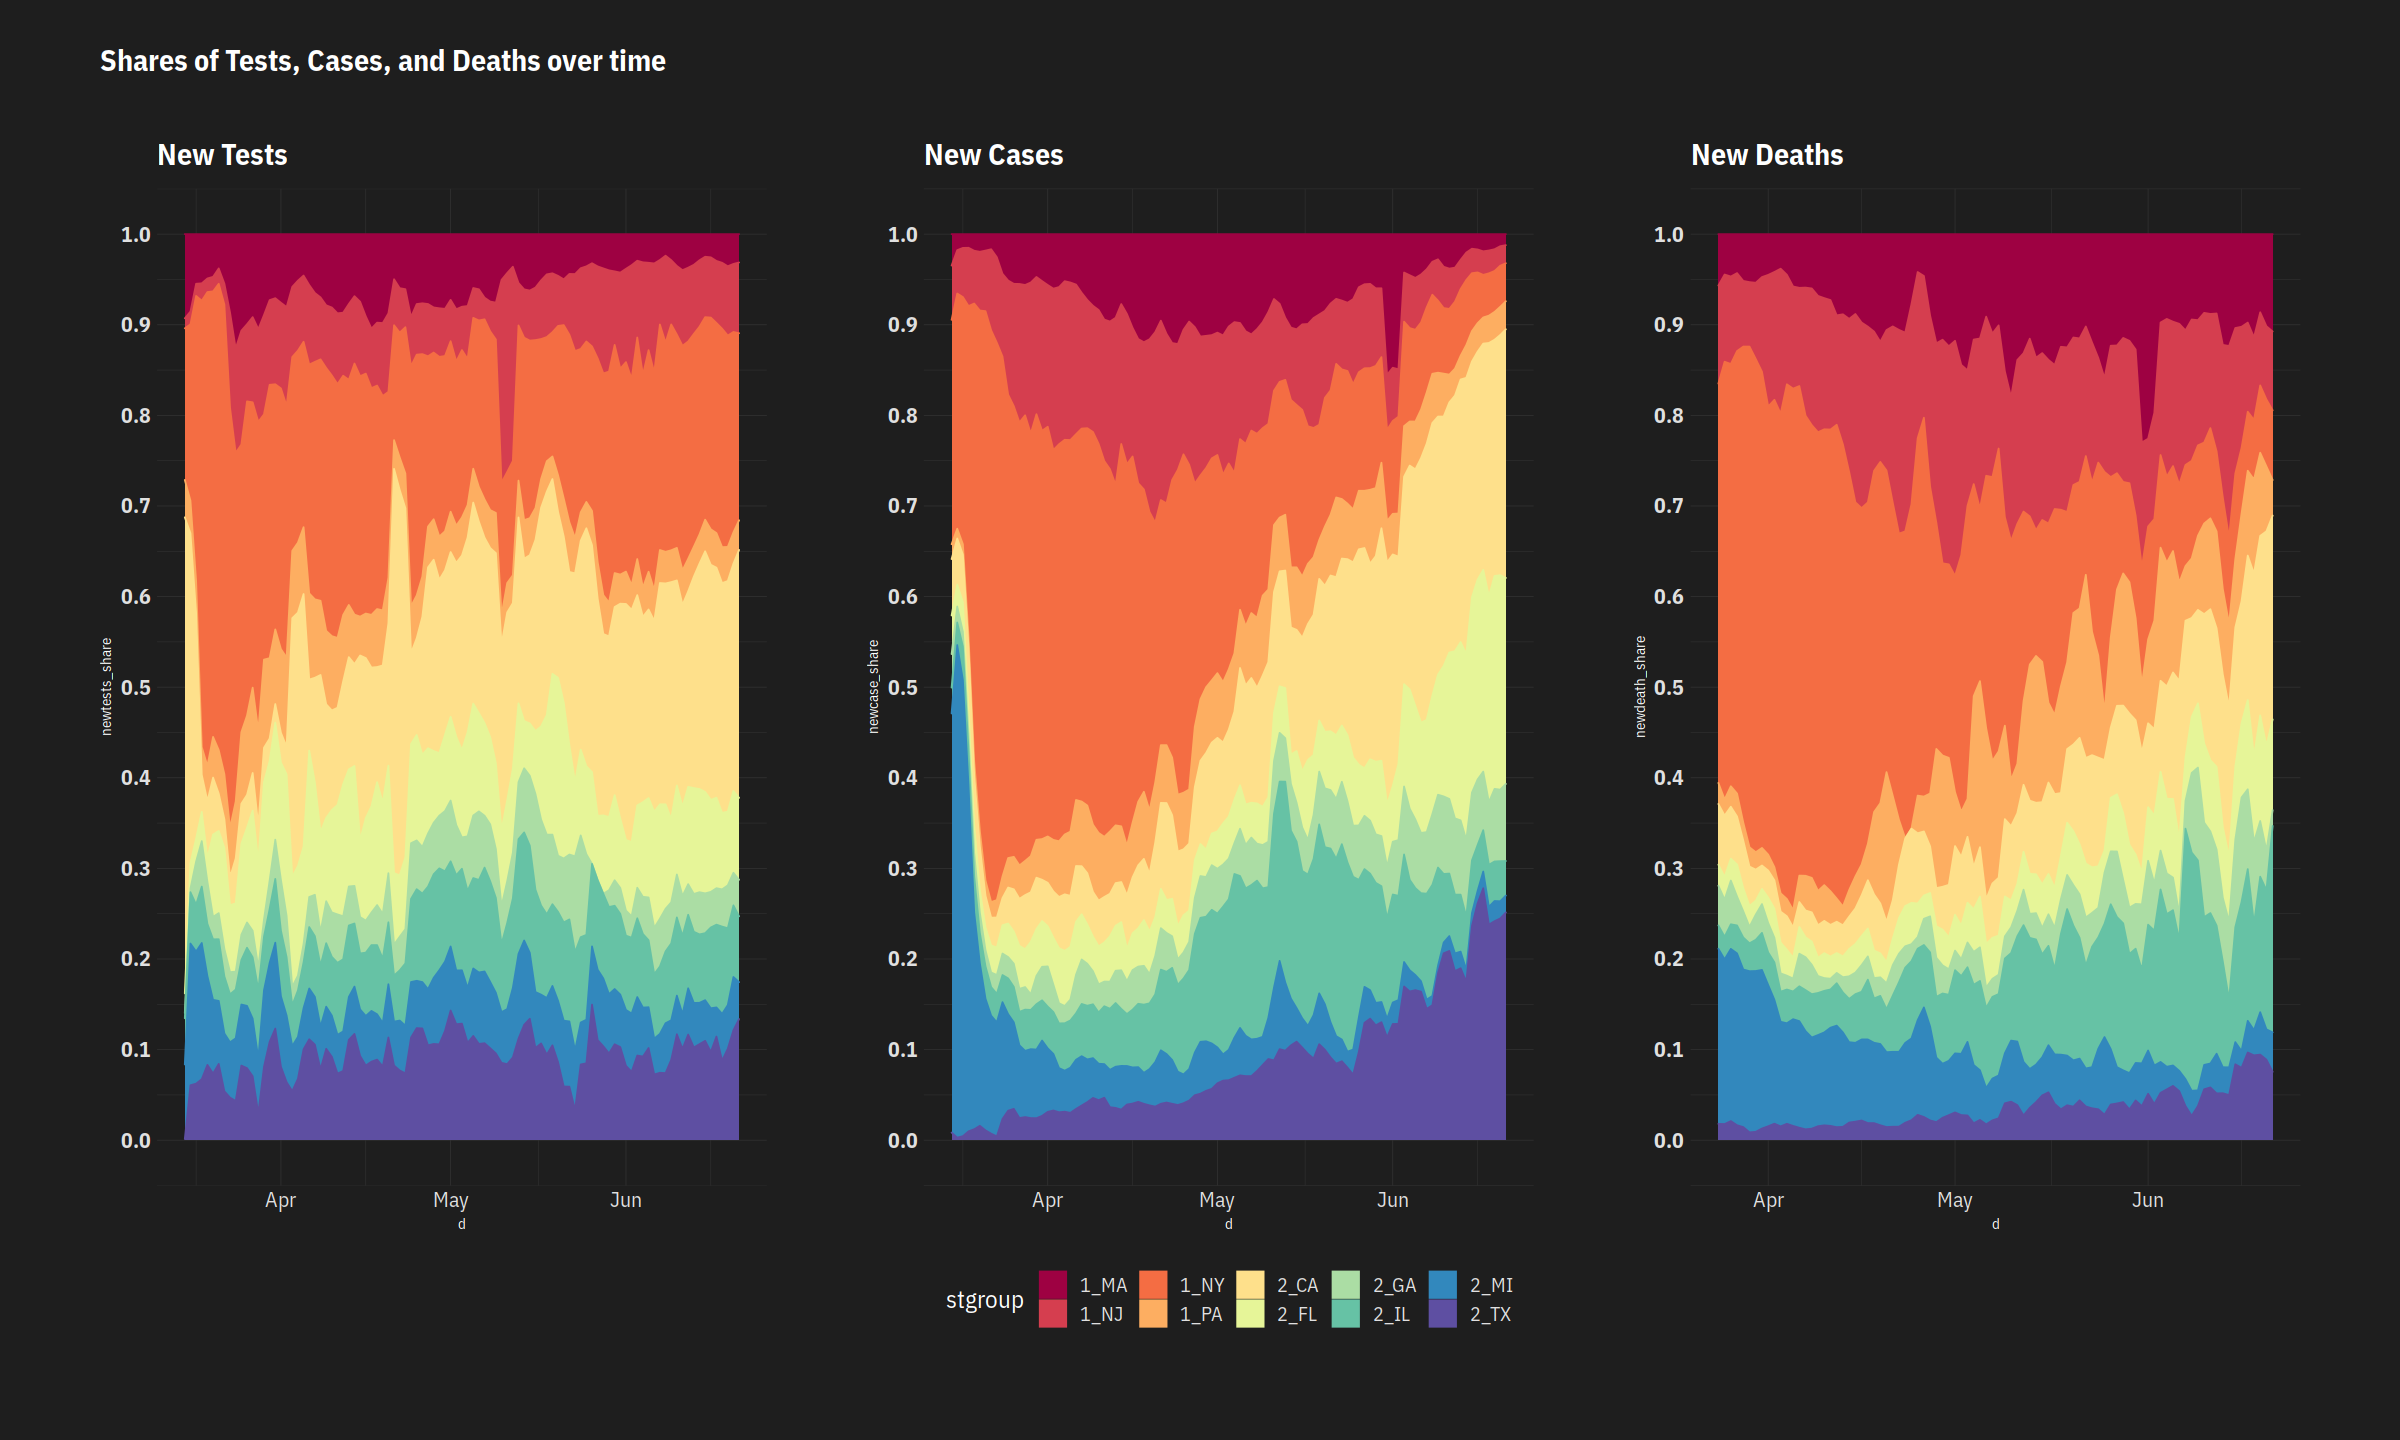

In [29]:
p1 = ggplot(t10states[d >= "2020-03-15"], aes(x = d, y = newcase_share, fill = stgroup, colour = stgroup)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases")
p2 = ggplot(t10states[d >= "2020-03-24"], aes(x = d, y = newdeath_share, fill = stgroup, colour = stgroup)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    theme(legend.position = "None") + 
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Deaths")
p3 = ggplot(t10states[d >= "2020-03-15"], aes(x = d, y = newtests_share, fill = stgroup, colour = stgroup)) +
    geom_area(position="fill") +
    theme(legend.position = "None") + 
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Tests")
options(repr.plot.width = 20, repr.plot.height = 12)
p = (p3 | p1 | p2 ) + plot_annotation(title = "Shares of Tests, Cases, and Deaths over time")
p

In [30]:
ggsave("state_carpet.png", p, width = 20, height = 10)

Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (position_stack).”


## TPR

In [21]:
options(repr.plot.width = 15, repr.plot.height = 10)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”


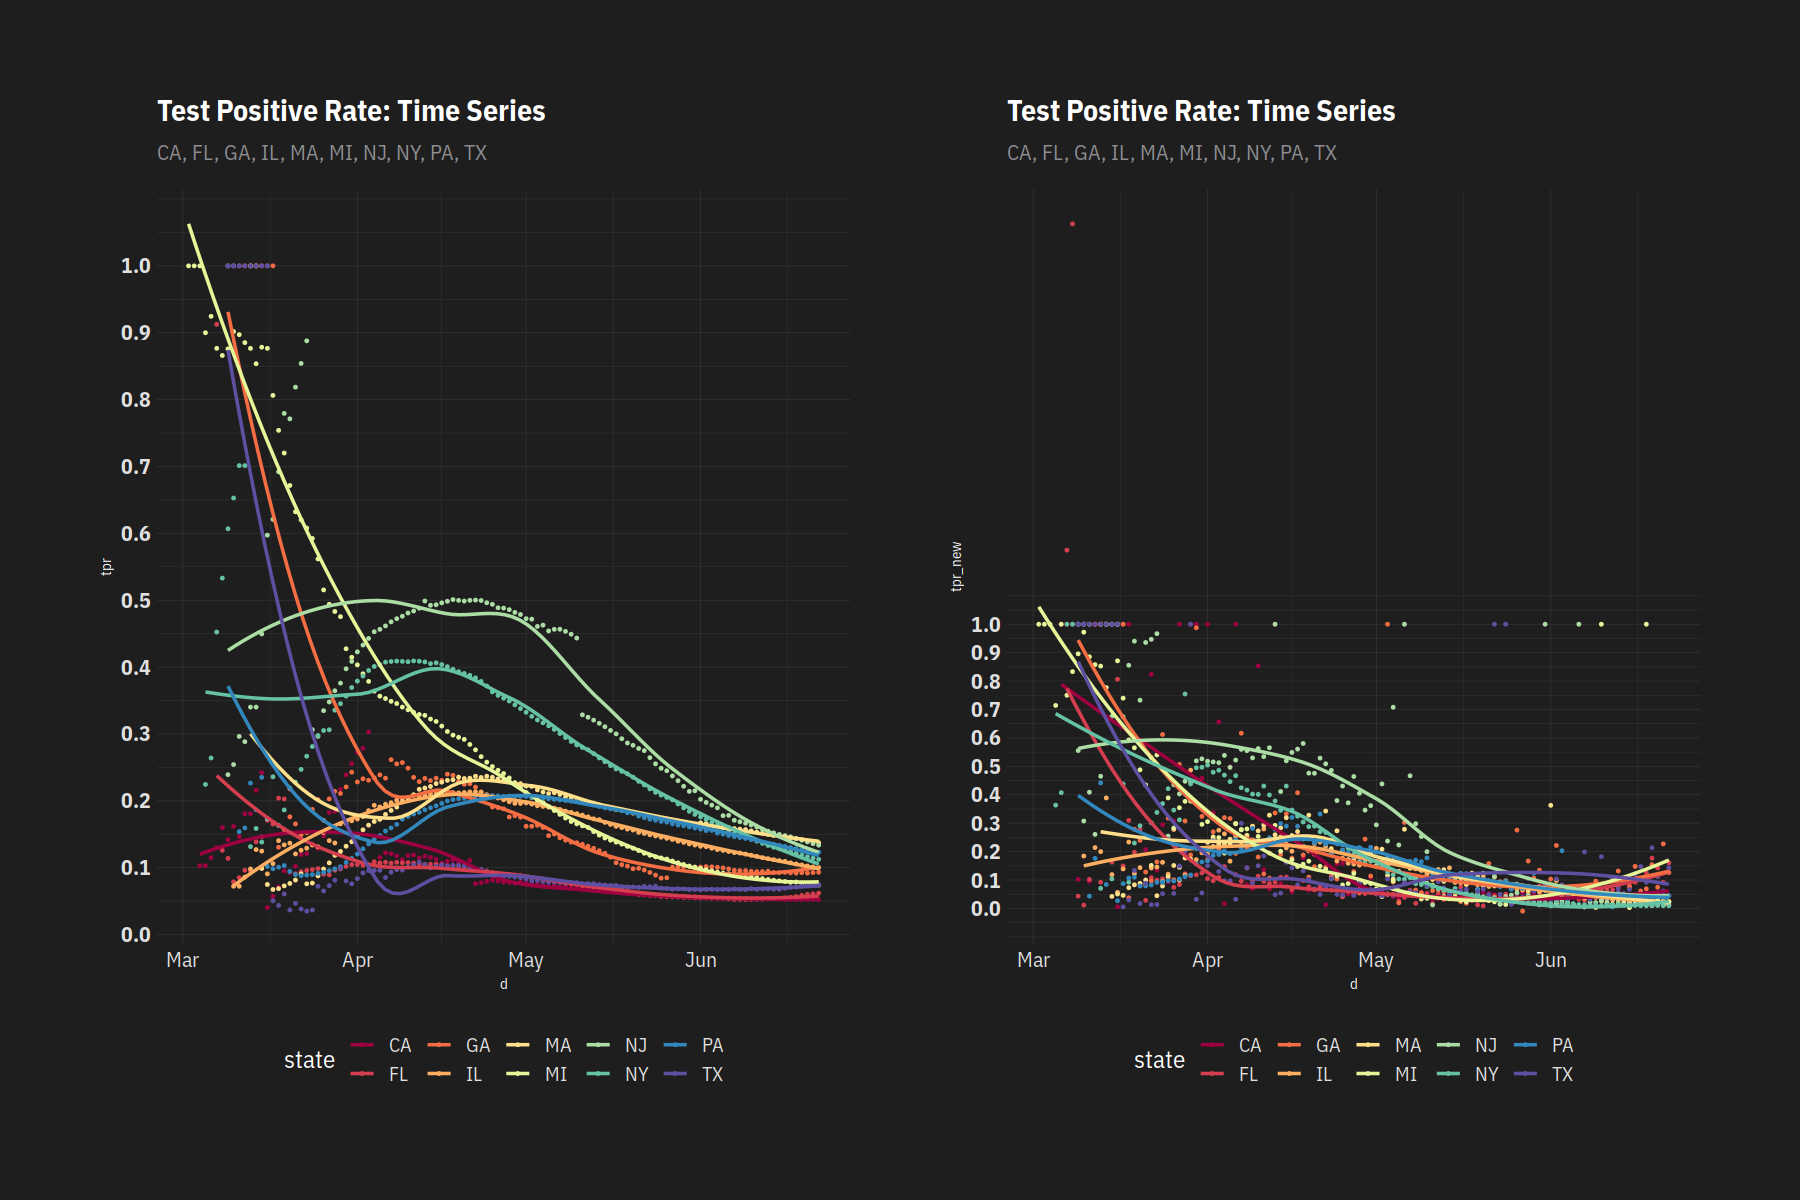

In [22]:
p1 = plot_ts(t10states, 'tpr', "Test Positive Rate: Time Series", T, F) +
    scale_y_continuous(breaks = seq(0, 1, .1))

p2 = plot_ts(t10states, 'tpr_new', "Test Positive Rate: Time Series", T, F) +
    scale_y_continuous(breaks = seq(0, 1, .1))

p1 | p2 

# Day-of-week effects 

In [23]:
dt = t10states[d >= '2020-03-15']
dt[, wknd := ifelse(day %in% c("Saturday", "Sunday"), 1, 0)]
dt[, t := date - 20200315] # time trend 
dt$day2 = as.factor(dt$day) 

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


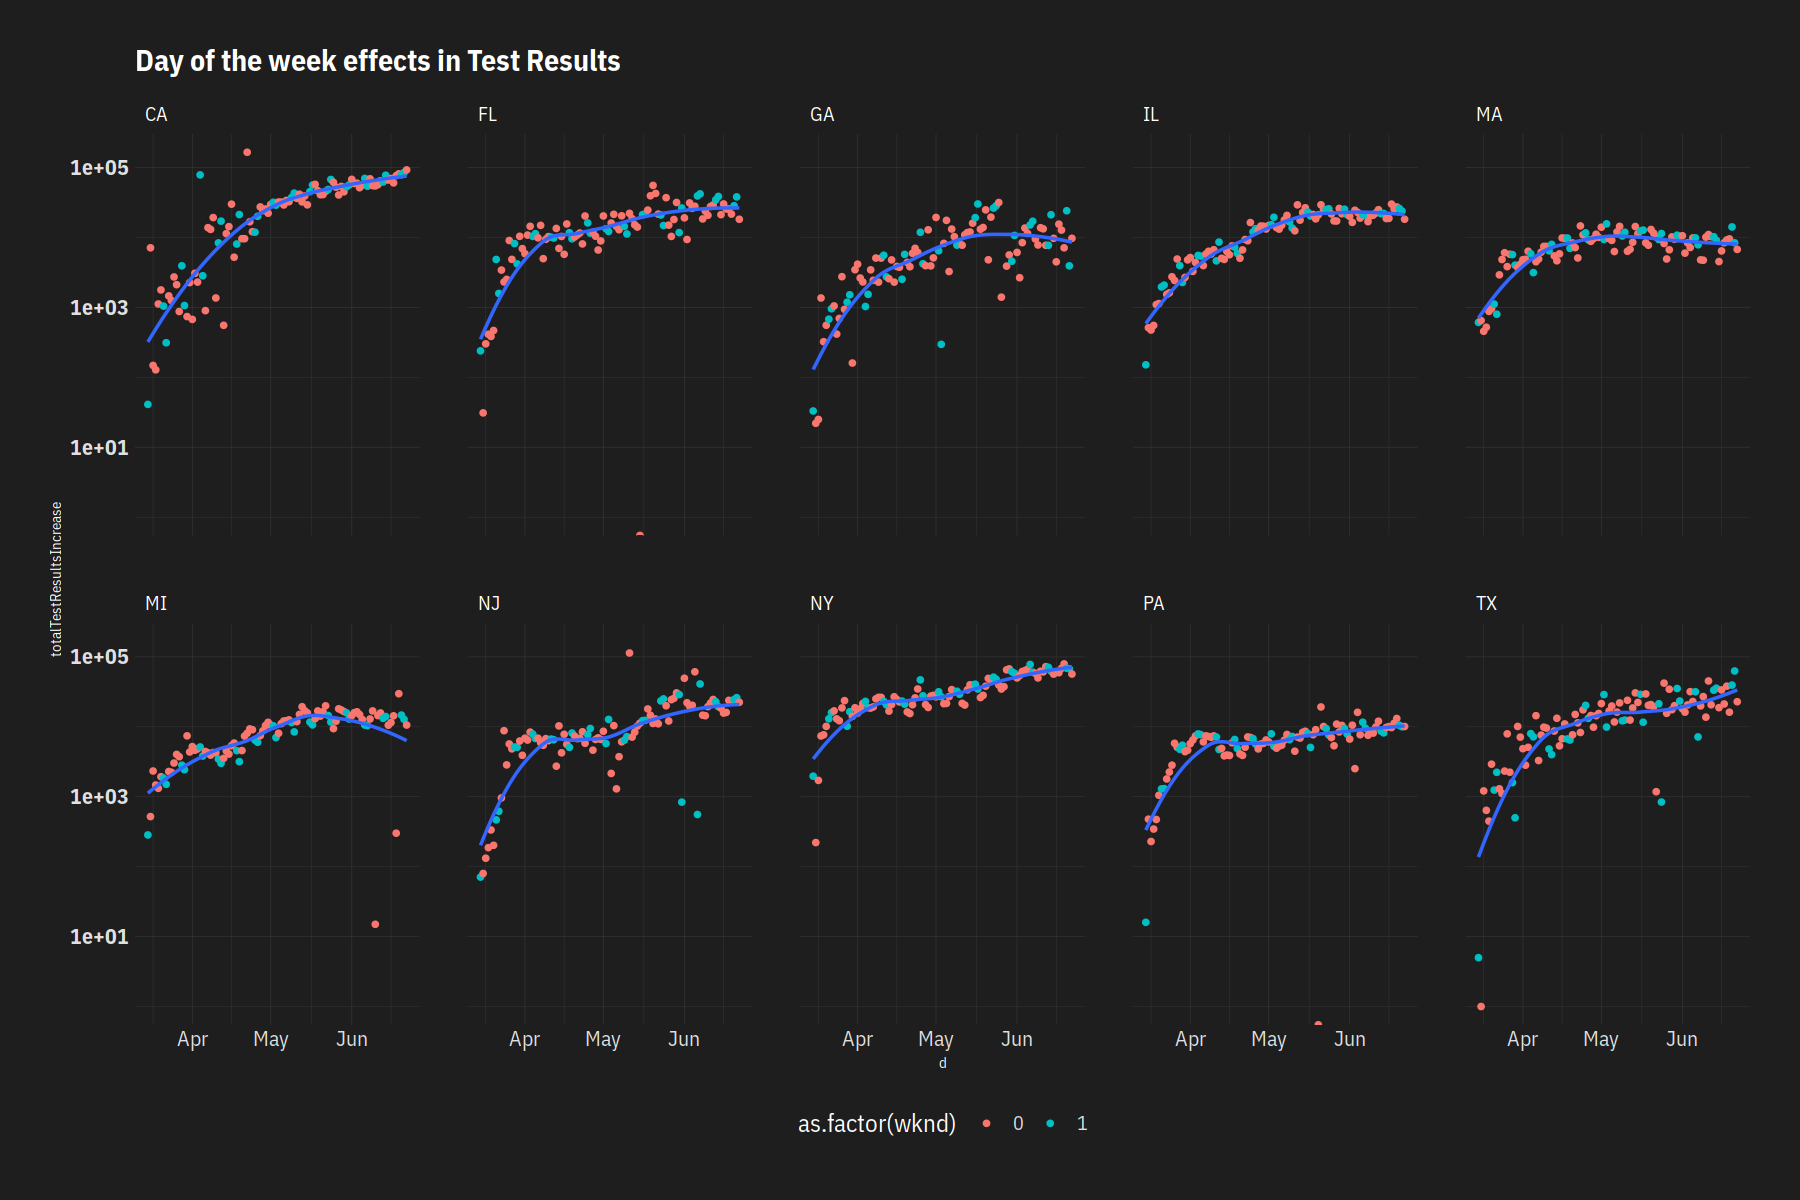

In [24]:
(p = ggplot(dt, aes(d, y = totalTestResultsIncrease)) +
    geom_point(aes(colour = as.factor(wknd))) + 
    geom_smooth(se = F) +
    labs(title = "Day of the week effects in Test Results") +
    facet_wrap(~ state, 2) +
    scale_y_log10()
)

In [25]:
day_of_week_plot = function(df){
    d = df %>% filter(term != "(Intercept)") %>% 
        mutate(day = str_replace(term, "relevel\\(day2, 2\\)", "")) %>% 
        mutate(ord_day = case_when(
            day == "Monday" ~ 1,  day == "Tuesday" ~ 2,  day == "Wednesday" ~ 3,  day == "Thursday" ~ 4, 
            day == "Friday" ~ 5,  day == "Saturday" ~ 6,  day == "Sunday" ~ 7
        ), wknd = as.factor(ifelse(day %in% c("Saturday", "Sunday"), 1, 0))) %>% 
        mutate(ub = estimate + 1.96 * `std.error`, 
               lb = estimate - 1.96 * `std.error`)
    stname = unique(df$state)
    p = ggplot(d, aes(x = ord_day,y = estimate, colour = wknd)) +
        geom_point() + 
        theme(legend.position = "None") +
        geom_pointrange(aes(ymin = lb, ymax = ub)) + 
        labs(title = stname)
}

Warning message in log(totalTestResultsIncrease + 1):
“NaNs produced”


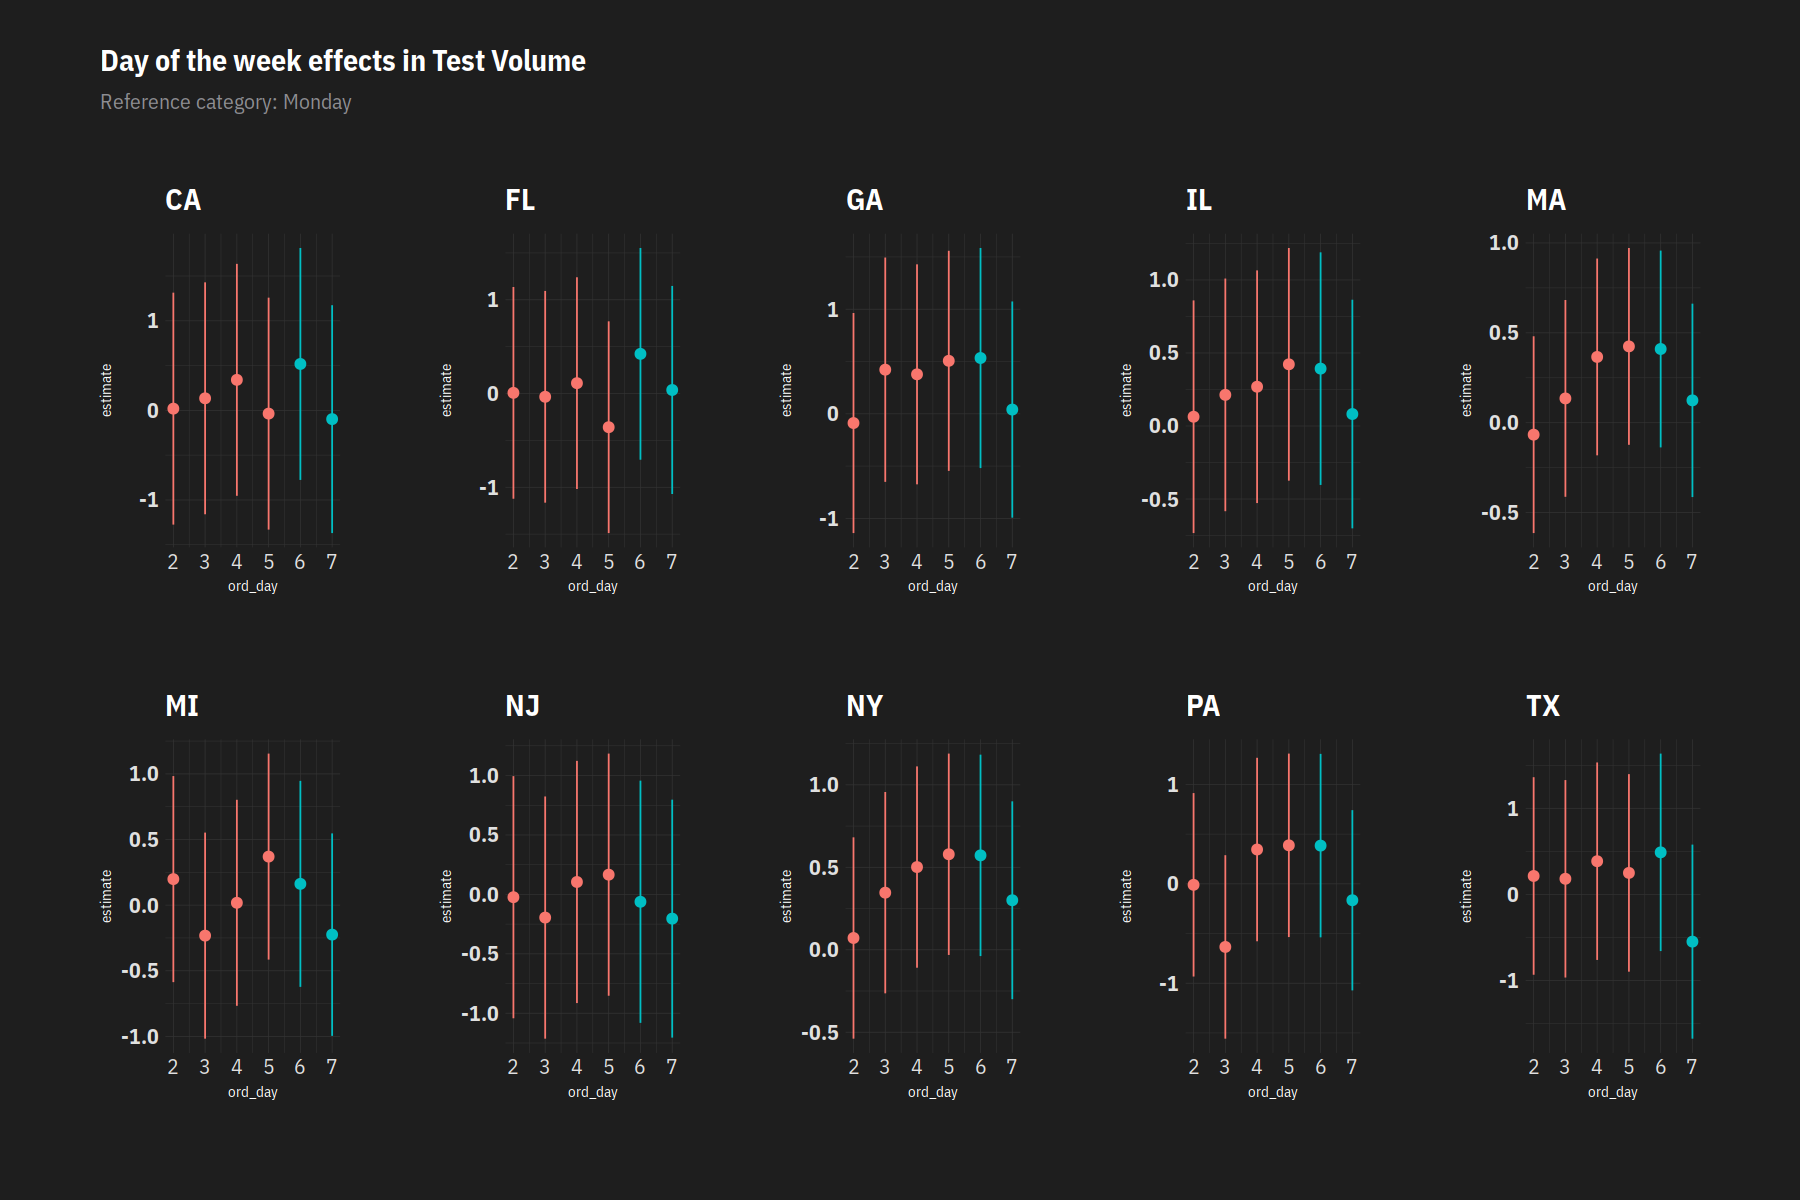

In [26]:
test_increase_regs = dt %>% group_by(state) %>% group_map( ~ lm(log(totalTestResultsIncrease+1) ~ relevel(day2, 2), .x) %>% 
                tidy %>% mutate(state = .y[[1]]), .keep = T) 
dow_plots = map(test_increase_regs , day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in Test Volume',
    subtitle = 'Reference category: Monday',
)

Warning message:
“The `keep` argument of `group_map()` is deprecated as of dplyr 1.0.0.
Please use the `.keep` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


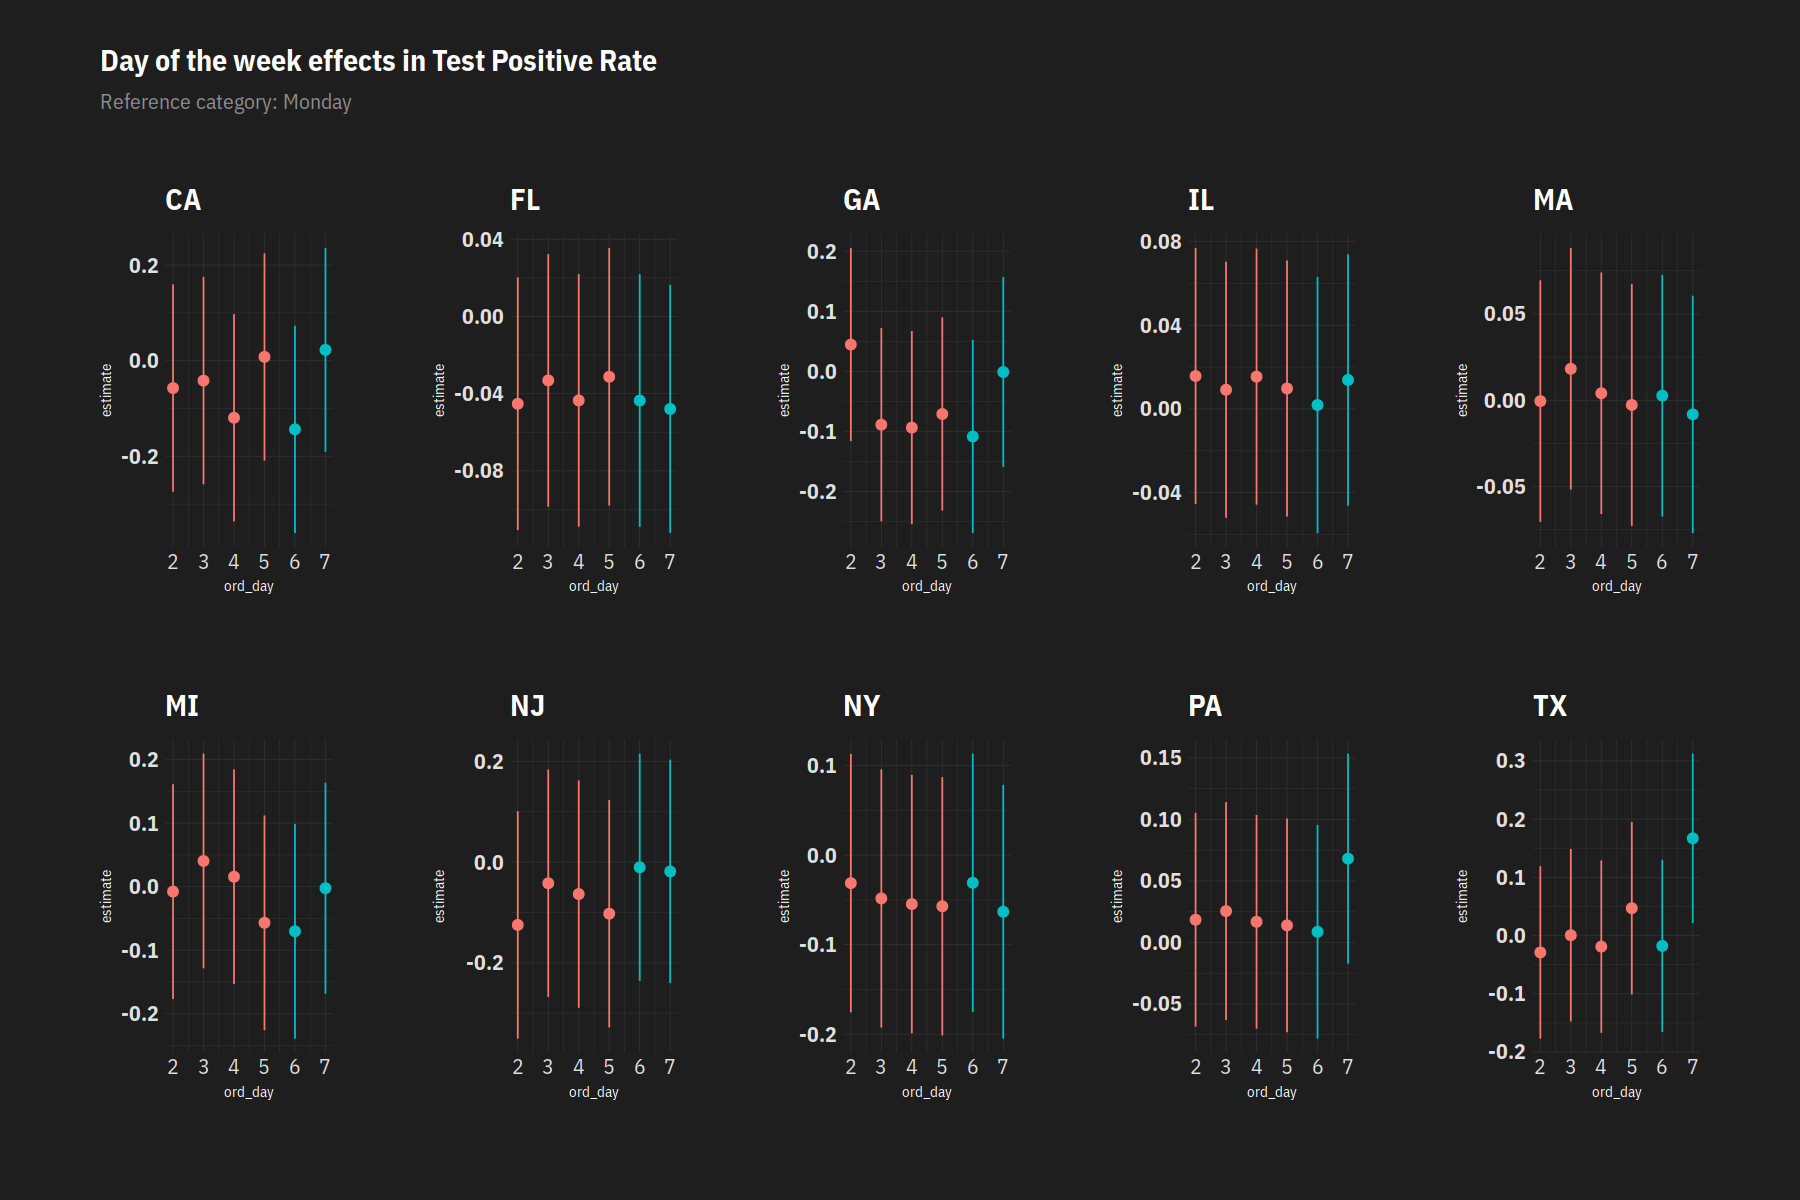

In [27]:
positive_rate = dt %>% group_by(state) %>% group_map( ~ lm(tpr_new ~ relevel(day2, 2), .x) %>% tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(positive_rate, day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in Test Positive Rate',
    subtitle = 'Reference category: Monday',
)

Warning message in log(deathIncrease + 1):
“NaNs produced”


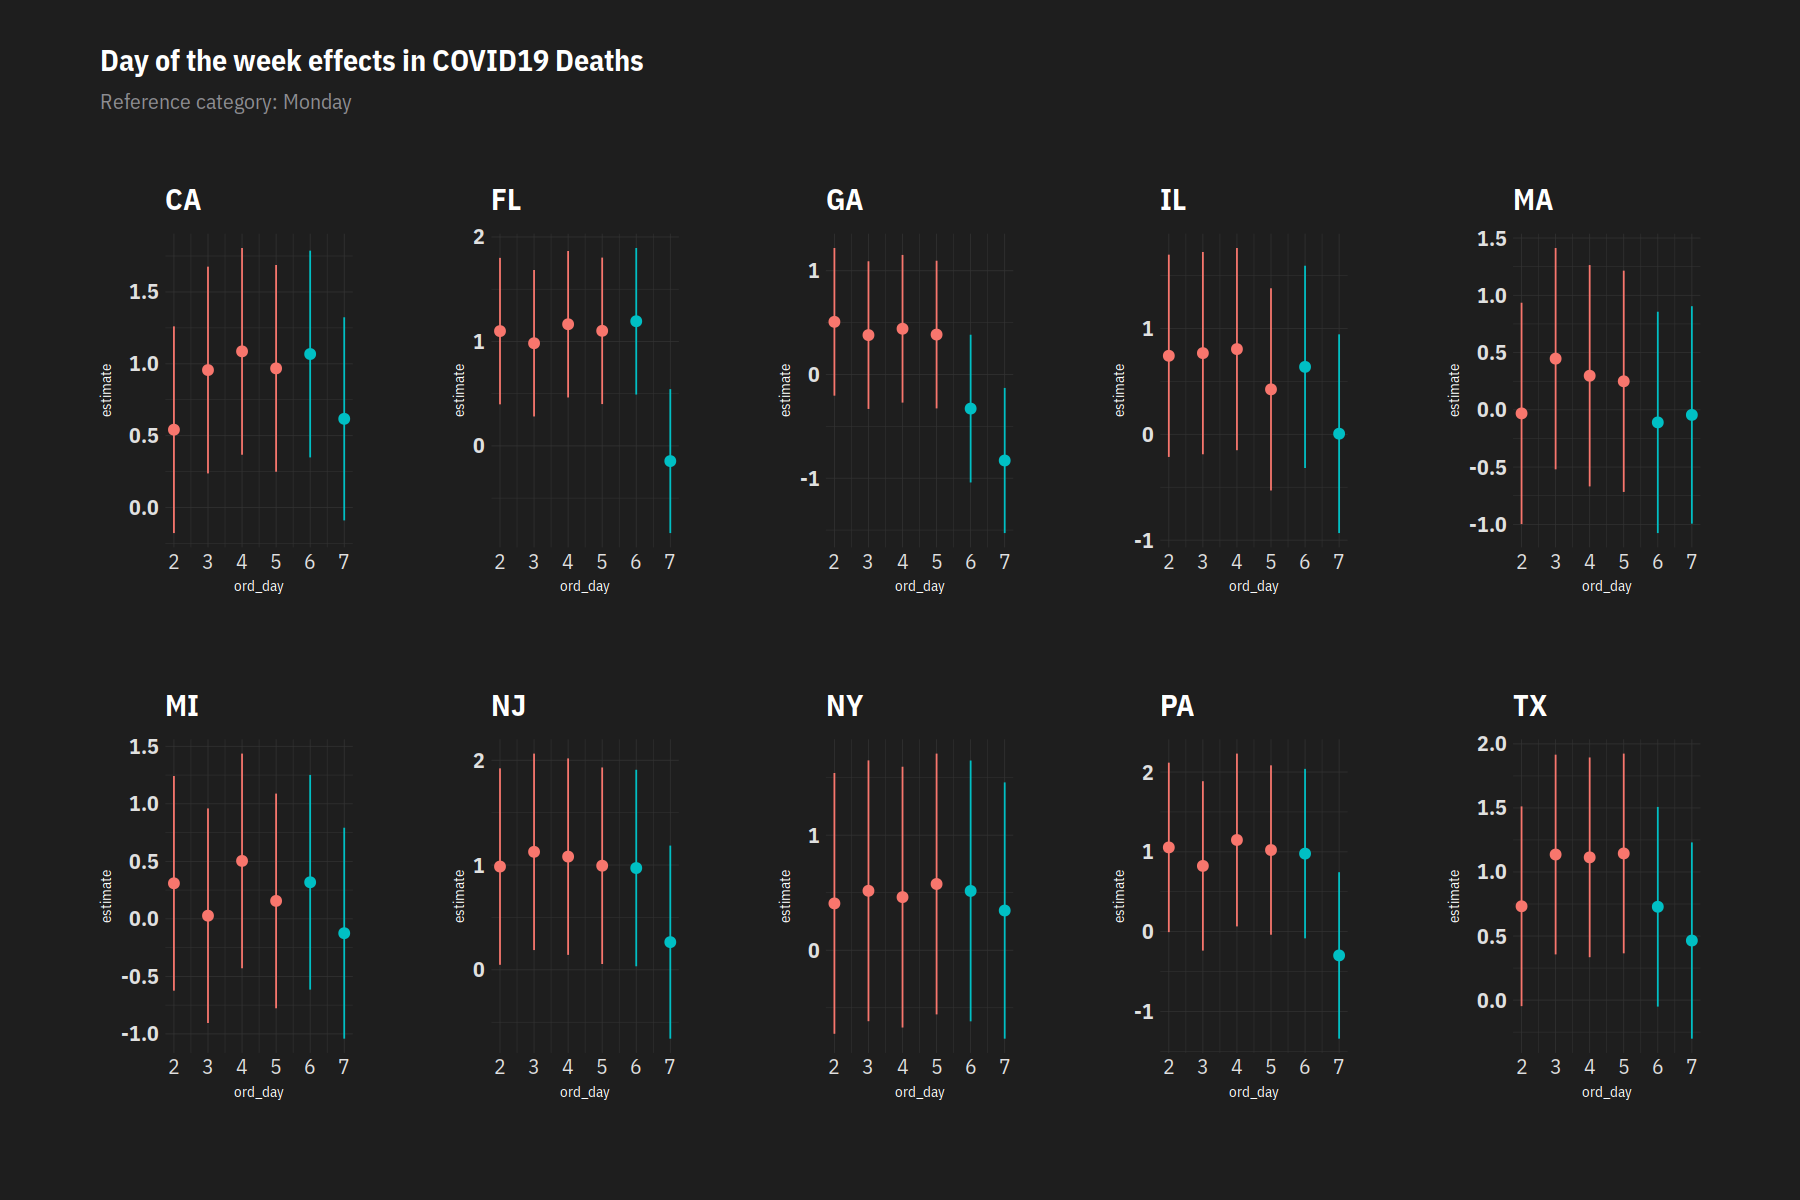

In [28]:
dths = dt %>% group_by(state) %>% group_map( ~ lm(log(deathIncrease+1) ~ relevel(day2, 2), .x) %>% tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(dths, day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in COVID19 Deaths',
    subtitle = 'Reference category: Monday',
)